<a href="https://colab.research.google.com/github/data-enhanced/Jupyter_Notebooks/blob/main/Titanic_BinaryClassification_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic EDA & Prep
**Example by David Cochran**

Using the Titanic dataset from [this](https://www.kaggle.com/c/titanic/overview) Kaggle competition.

Fields include:

- **Name** (str) - Name of the passenger
- **Pclass** (int) - Ticket class
- **Sex** (str) - Sex of the passenger
- **Age** (float) - Age in years
- **SibSp** (int) - Number of siblings and spouses aboard
- **Parch** (int) - Number of parents and children aboard
- **Ticket** (str) - Ticket number
- **Fare** (float) - Passenger fare
- **Cabin** (str) - Cabin number
- **Embarked** (str) - Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## Import Libraries & Set Default Plot Attributes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from time import time

# Machine Learning Training, Scoring, and Metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import auc, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, plot_roc_curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, classification_report

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

In [3]:
# Customize seaborn plot styles

# Adjust to retina quality
# https://blakeaw.github.io/2020-05-25-improve-matplotlib-notebook-inline-res/
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Adjust dpi and font size
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook', font_scale = 0.8)

# Display tick marks
sns.set_style('ticks')

# Remove borders
plt.rc('axes.spines', top=False, right=False, left=False, bottom=False)

In [4]:
# Define custom colors using c preface for "custom"
cp1 = sns.color_palette('tab10')
cp2colors = cp1[:1:-1] + [cp1[0]]
cp2 = sns.color_palette(cp2colors)

# Name specific colors for convenience
cblue = cp1[0] 
cgreen = cp1[2]
cbrown = cp1[5]
cgray = '#bbb'
chighlight = cp1[1] # Orange

# Define a binary, gray/orange color palette for binary classification
cpbinary = sns.color_palette([cgray, chighlight])

# Create a diverging palette for correlation heatmaps
cpdiverg = sns.color_palette('coolwarm')

# Custom Palette for model performance plot, ranking high to low
cp3 = sns.hls_palette(10, l=.4)

# Set default palette
sns.set_palette(cpbinary) # For binary classification plots, set this as default

## Read and Review Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Predictive Analytics/Titanic Project/data/titanic.csv')

# View 10 records taken as a random sample
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
762,763,1,3,"Barah, Mr. Hanna Assi",male,20.000,0,0,2663,7.229,NaN,C
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.000,1,0,113776,66.600,C2,S
201,202,0,3,"Sage, Mr. Frederick",male,nan,8,2,CA. 2343,69.550,NaN,S
406,407,0,3,"Widegren, Mr. Carl/Charles Peter",male,51.000,0,0,347064,7.750,NaN,S
768,769,0,3,"Moran, Mr. Daniel J",male,nan,1,0,371110,24.150,NaN,Q
733,734,0,2,"Berriman, Mr. William John",male,23.000,0,0,28425,13.000,NaN,S
448,449,1,3,"Baclini, Miss. Marie Catherine",female,5.000,2,1,2666,19.258,NaN,C
659,660,0,1,"Newell, Mr. Arthur Webster",male,58.000,0,2,35273,113.275,D48,C
65,66,1,3,"Moubarek, Master. Gerios",male,nan,1,1,2661,15.246,NaN,C
777,778,1,3,"Emanuel, Miss. Virginia Ethel",female,5.000,0,0,364516,12.475,NaN,S


In [7]:
# View dataframe fundamentals
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Drop irrelevant columns
These appear irrelevant to predicting survival:
- PassengerId
- Name
- Ticket

In [8]:
df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.000,1,0,7.250,NaN,S
1,1,1,female,38.000,1,0,71.283,C85,C
2,1,3,female,26.000,0,0,7.925,NaN,S
3,1,1,female,35.000,1,0,53.100,C123,S
4,0,3,male,35.000,0,0,8.050,NaN,S


# Explore & Plot Continuous (and ordinal) Features

- **Survived** is actually categorical: 1 = yes; 0 = no --> but it is the target variable, so we will keep it for exploration with the continuous features
- **Pclass** is ordinal: 1st, 2nd, 3rd classes
- **Age** 
- **SibSp** is ordinal: 1, 2, 3, etc. siblings or spouses
- **Parch** is ordinal: 1, 2, 3, etc. parents or children 
- **Fare**

In [9]:
# View descriptive stats for continuous and ordinal variables + Survived
cont = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
df[cont].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,714.000,891.000,891.000,891.000
mean,0.384,2.309,29.699,0.523,0.382,32.204
std,0.487,0.836,14.526,1.103,0.806,49.693
min,0.000,1.000,0.420,0.000,0.000,0.000
25%,0.000,2.000,20.125,0.000,0.000,7.910
50%,0.000,3.000,28.000,0.000,0.000,14.454
75%,1.000,3.000,38.000,1.000,0.000,31.000
max,1.000,3.000,80.000,8.000,6.000,512.329


**Note:** These are actually ordinal variables, with a small number of discrete possible values, meaningfully ordered:
- Pclass
- SibSp
- Parch

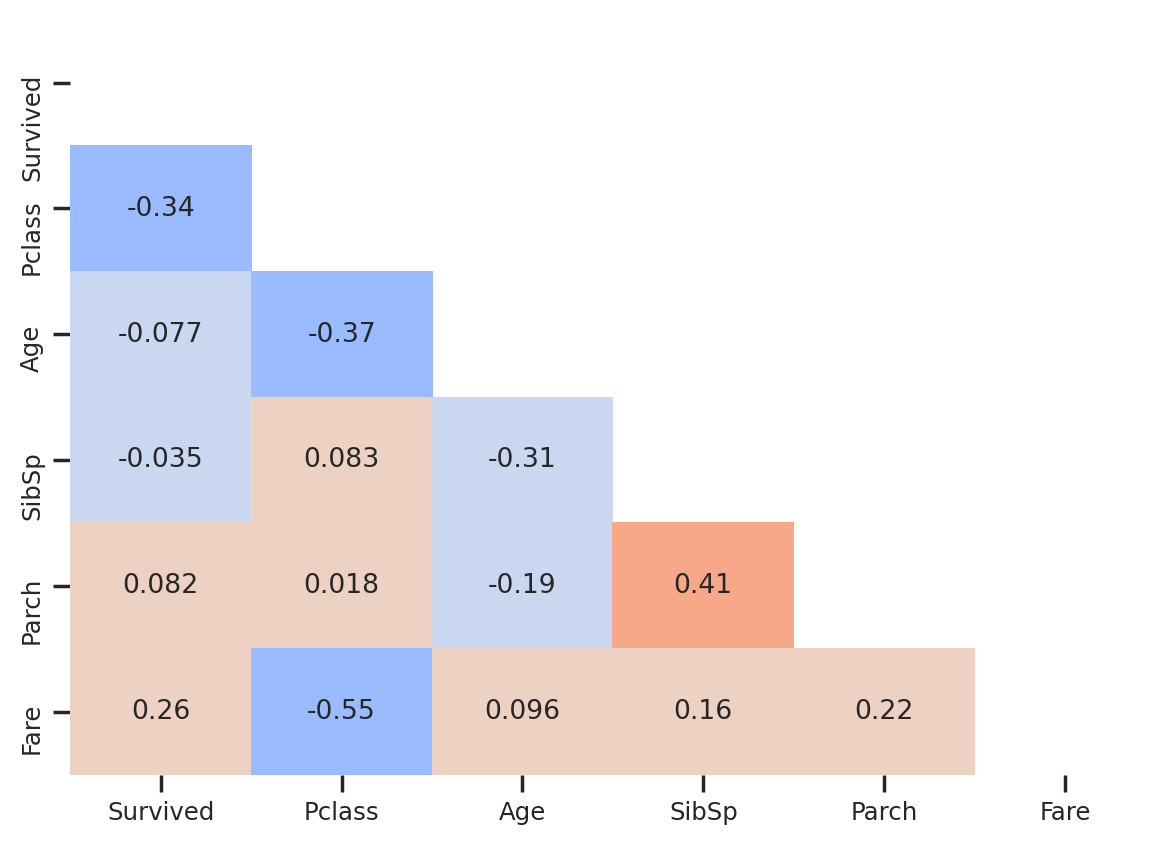

In [10]:
# Plot correlation with Seaborn
mask = np.triu(np.ones_like(df.corr()))
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(), cmap=cpdiverg, vmin=-1, vmax=1, mask=mask, annot=True, cbar=False);

Pretty strong correlation between SibSp and Parch -- both regarding # of family members. The similarity would suggest we may do well to combine these.

In [11]:
# Compare feature means grouped by Survived
df[cont].groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,2.532,30.626,0.554,0.330,22.118
1,1.950,28.344,0.474,0.465,48.395


**Notes:**
- Pclass: survivors tended to be upper class (1st or 2nd)
- Age: survivors were slightly younger
- SubSp: survivors averaged fewer siblings
- Parch: survivors averaged slightly higher parent/child relations
- Fare: survivors had more expensive tickets

### Explore Age

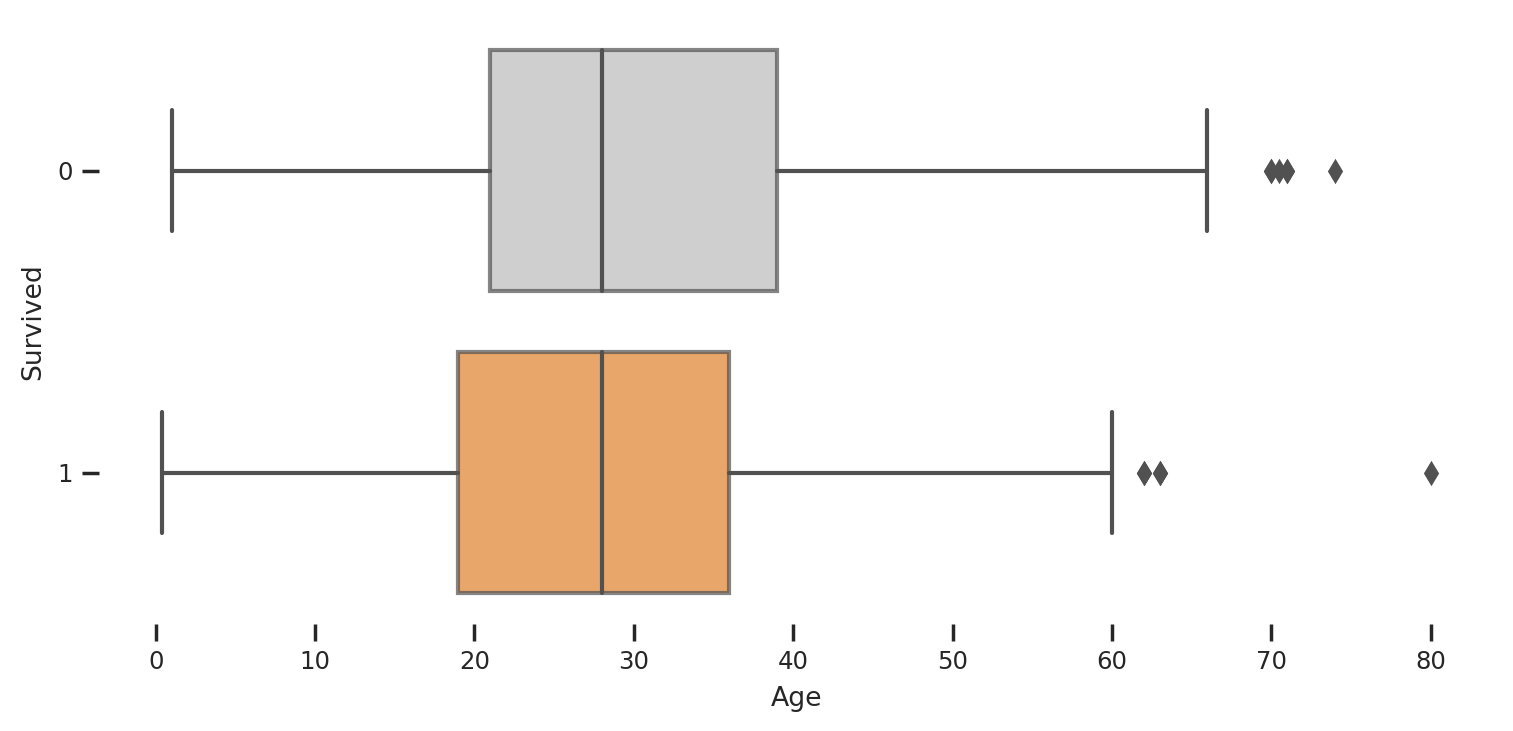

In [12]:
plt.figure(figsize=(9,4))
ax = sns.boxplot(data=df, x='Age', y='Survived', orient='h', boxprops=dict(alpha=0.7));

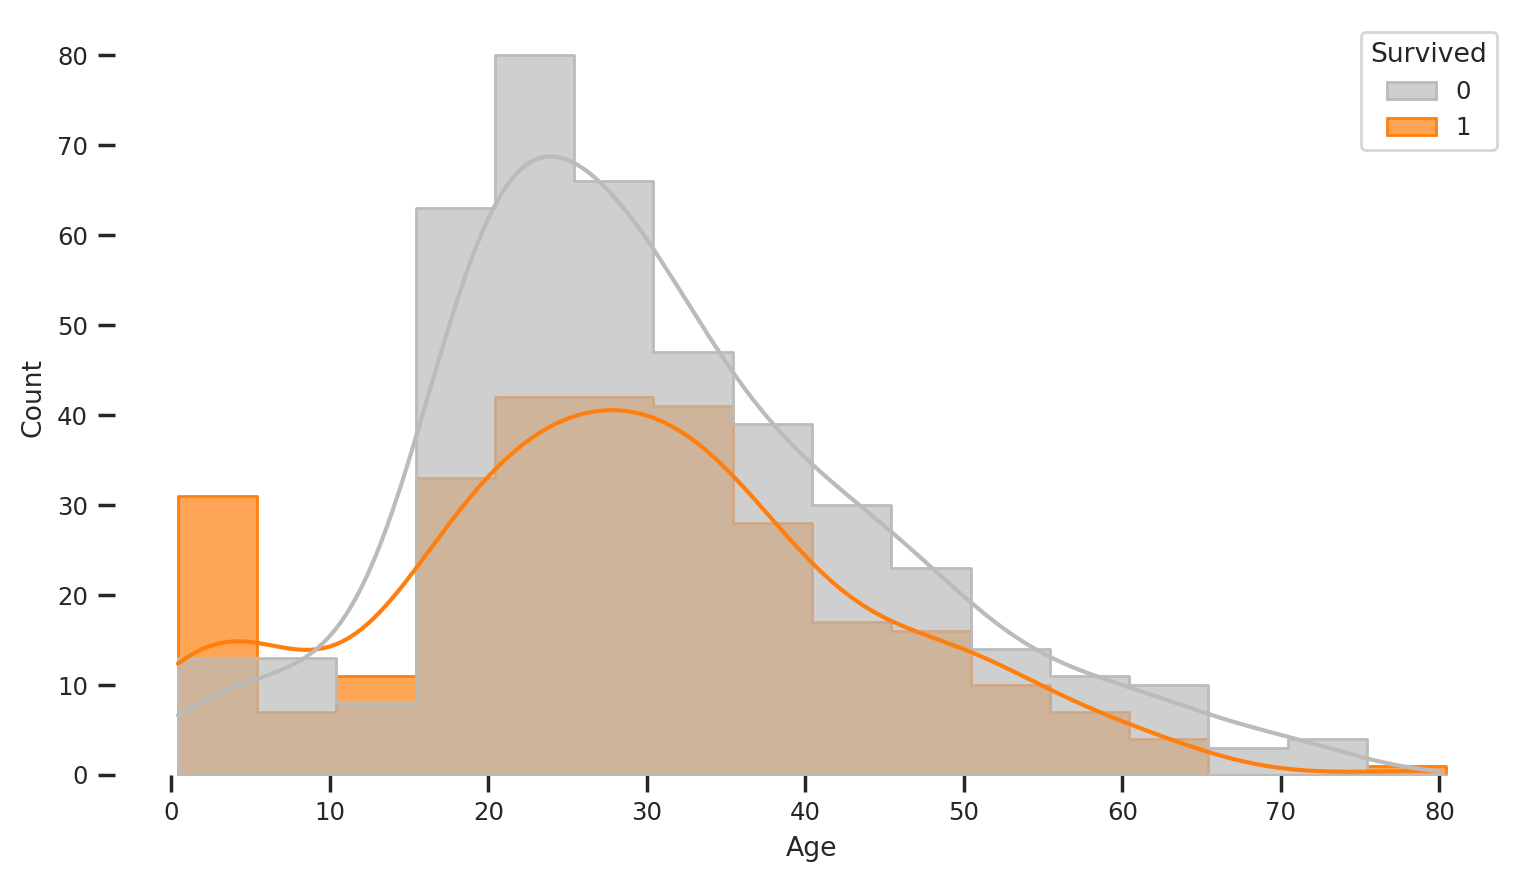

In [13]:
plt.figure(figsize=(9,5))
sns.histplot(data=df, x='Age', hue='Survived', binwidth=5, element='step', alpha=0.7, kde=True);

**Interpretation:**
The age distributions for both survivors (1) and non-survivors (0) are very similar _except:_
- Survivors were just slightly younger, on average.
- Very young passengers (ages 0-5) and young teens were more likely to survive.
- The oldest passenger(s) survived.

### Investigate impact of null values for Age

In [14]:
# How many null values for Age?
df['Age'].isnull().sum()

177

View means for continuous features grouped by Age = null:

In [15]:
df[cont].groupby(df['Age'].isnull()).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,
False,0.406,2.237,29.699,0.513,0.431,34.695
True,0.294,2.599,nan,0.565,0.181,22.159


**Interpretation:** 
- There is no obvious pattern to the differences in survival rates, or other features, when Age is null.
- Therefore, we can fill the missing values with the mean for Age.

### Explore Fare

Is there a pattern to survival rates by ticket price?

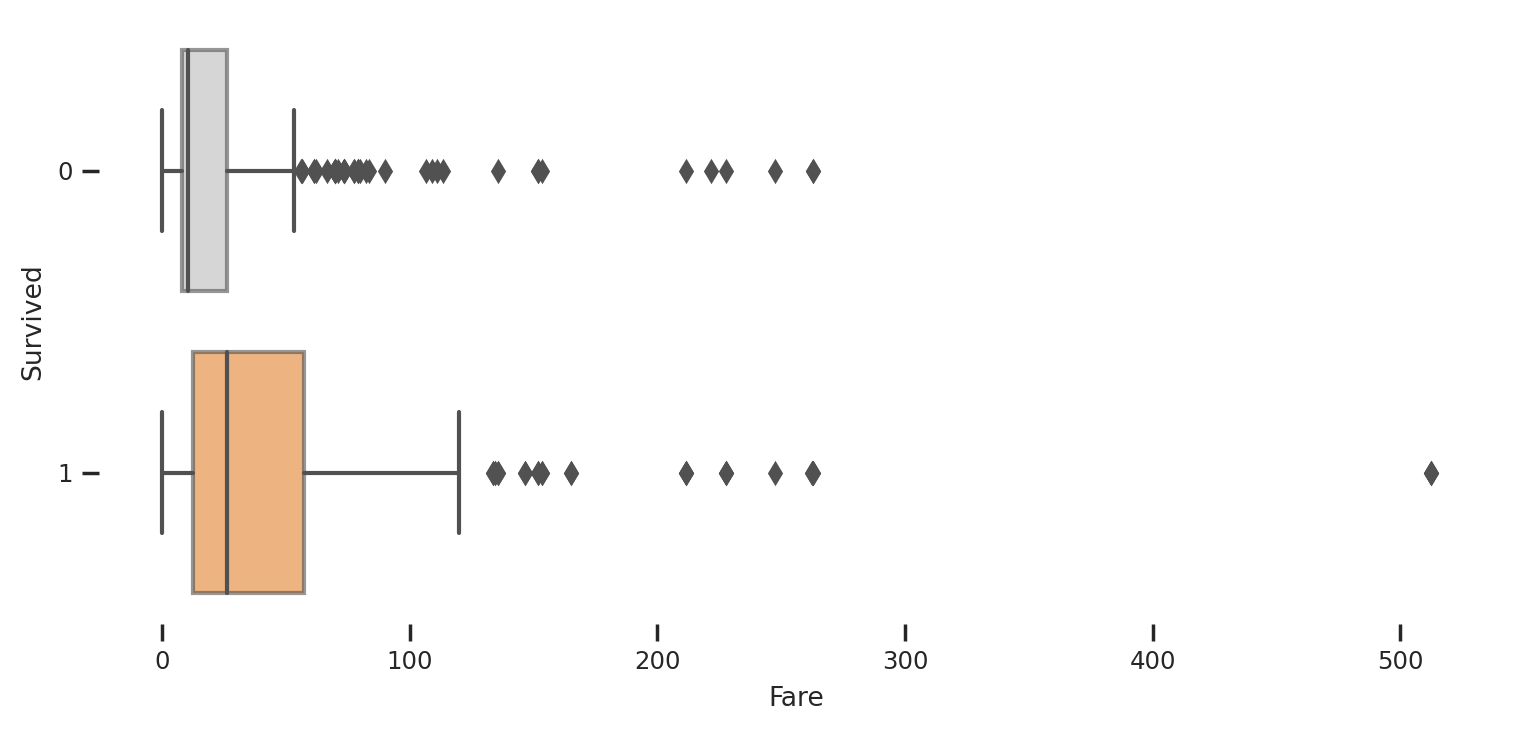

In [16]:
# Boxplot: Fare
plt.figure(figsize=(9,4))
ax = sns.boxplot(data=df, x='Fare', y='Survived', orient='h', boxprops=dict(alpha=0.6));

Survivors, on average, paid higher ticket prices.

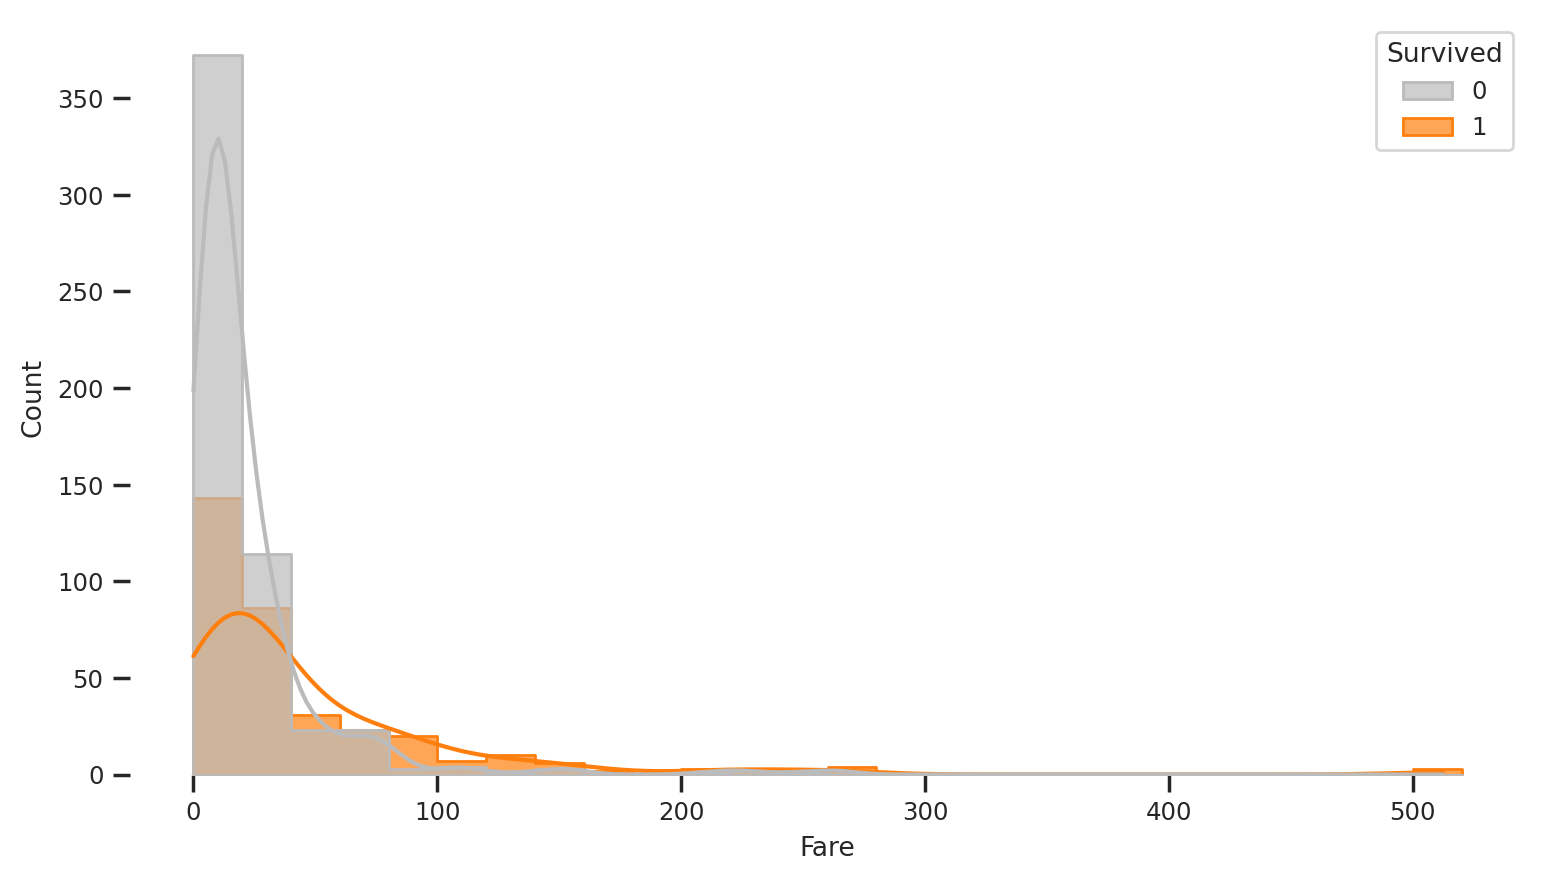

In [17]:
plt.figure(figsize=(9,5))
sns.histplot(data=df, x='Fare', hue='Survived', binwidth=20, element='step', alpha=0.7, kde=True);

Those with tickets priced circa 40 or above were more likely to survive.

### Continuous Variables Summary
- **Age** appears somewhat relevant to predicting survival. **177** null values need attention.
- **Fare** appears very relevant to predicting survival. Those with a ticket priced at $40 or greater were more likely to survive than not.

# Clean Continuous Data
- Fill nulls for Age with average age


### Fill Nulls for Age with Average Age

In [18]:
# View first few records with Age null
df[df['Age'].isnull()].head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
5,0,3,male,nan,0,0,8.458,NaN,Q
17,1,2,male,nan,0,0,13.000,NaN,S
19,1,3,female,nan,0,0,7.225,NaN,C
26,0,3,male,nan,0,0,7.225,NaN,C
28,1,3,female,nan,0,0,7.879,NaN,Q


In [19]:
# View the current most common ages
df['Age'].value_counts().head(10)

24.000    30
22.000    27
18.000    26
19.000    25
30.000    25
28.000    25
21.000    24
25.000    23
36.000    22
29.000    20
Name: Age, dtype: int64

In [20]:
# Fill missing age values with average age
df['Age'].fillna(df['Age'].mean(), inplace = True)

# View the new most common ages
df['Age'].value_counts().head(10)

29.699    177
24.000     30
22.000     27
18.000     26
28.000     25
30.000     25
19.000     25
21.000     24
25.000     23
36.000     22
Name: Age, dtype: int64

**NOTE:** 29.699118 is the mean age, which has replaced the 177 formerly null values.

# Explore & Plot Ordinal Variables
- Pclass
- SibSp
- Parch

In [21]:
# Does the mean value differ for survivors vs. non-survivors?
ord = ['Survived','Pclass','SibSp','Parch']
df[ord].groupby('Survived').mean()

,Pclass,SibSp,Parch
Survived,,,
0,2.532,0.554,0.330
1,1.950,0.474,0.465


**Interpretation:**
- Survivors tended to be first or second class.
- Survivors averaged slightly fewer siblings and/or spouses.
- Survivors averaged slightly more parent-child relationships.

### Explore Pclass

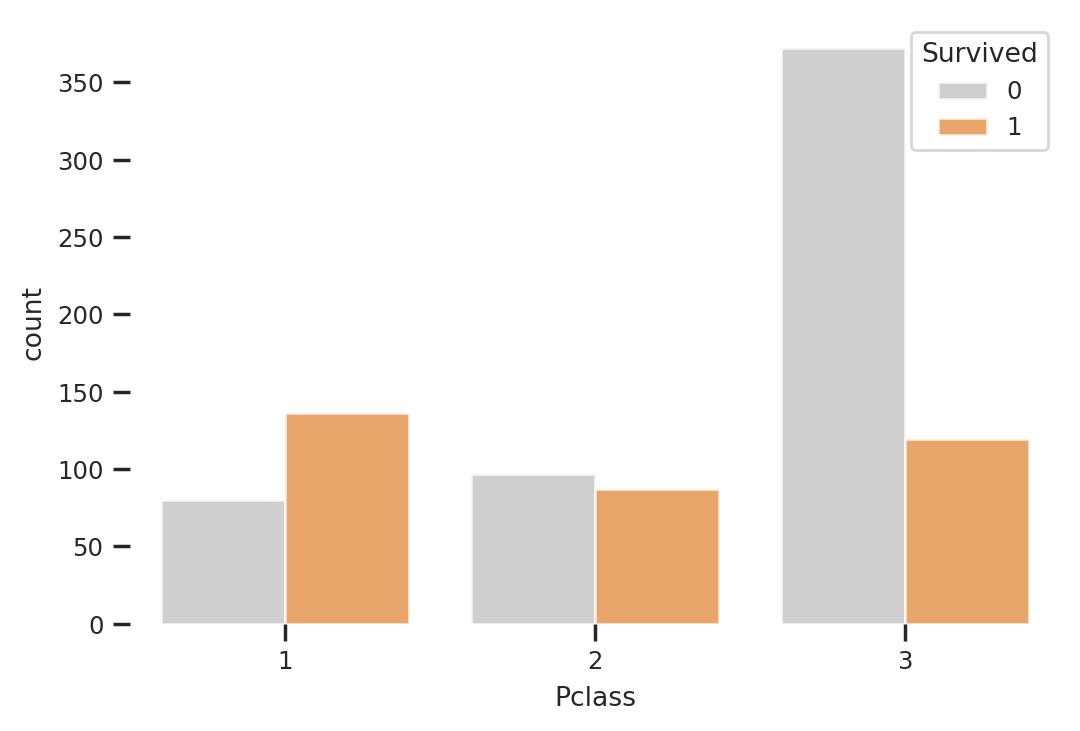

In [22]:
# Compare survivors vs. non-survivors by Pclass
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Pclass', hue='Survived', alpha=0.7);

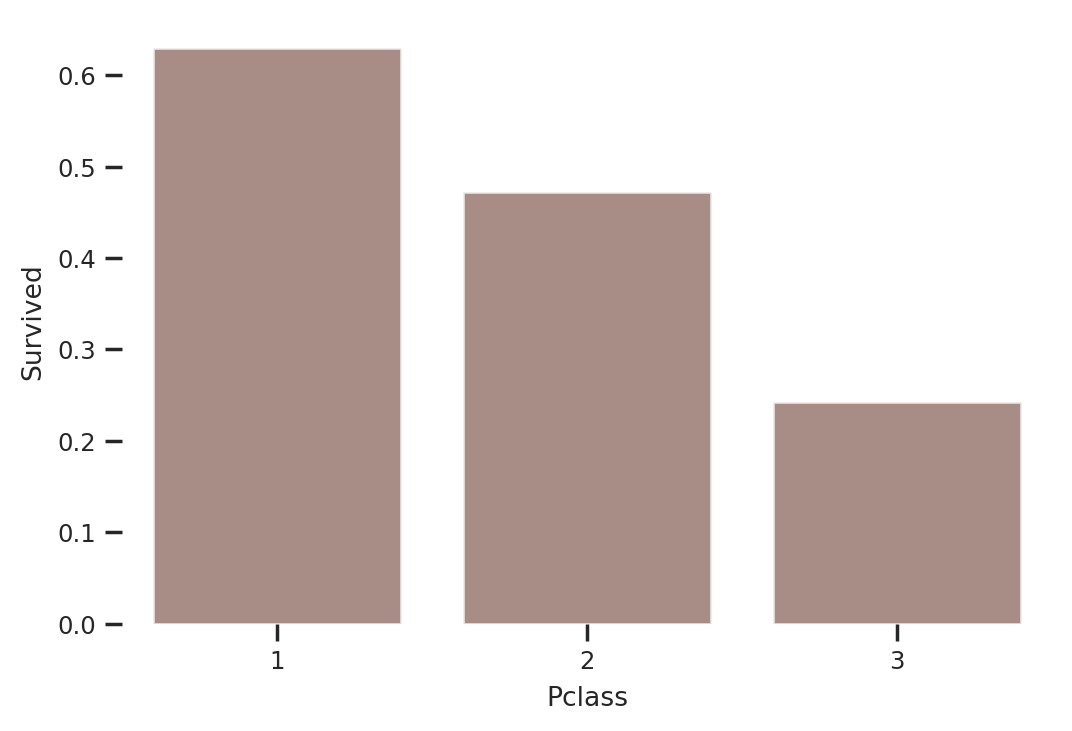

In [23]:
# Compare average survival rate by Pclass
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Pclass', y='Survived', ci=None, color=cbrown, alpha=0.7);

In [24]:
# Calculate average survival probability by Pclass
df['Survived'].groupby(df['Pclass']).mean()

Pclass
1   0.630
2   0.473
3   0.242
Name: Survived, dtype: float64

**Interpretation**: Pclass is *highly* relevant to predicting survival, with lower Pclass numbers corresponding with higher survival probability.

### Explore Sibsp

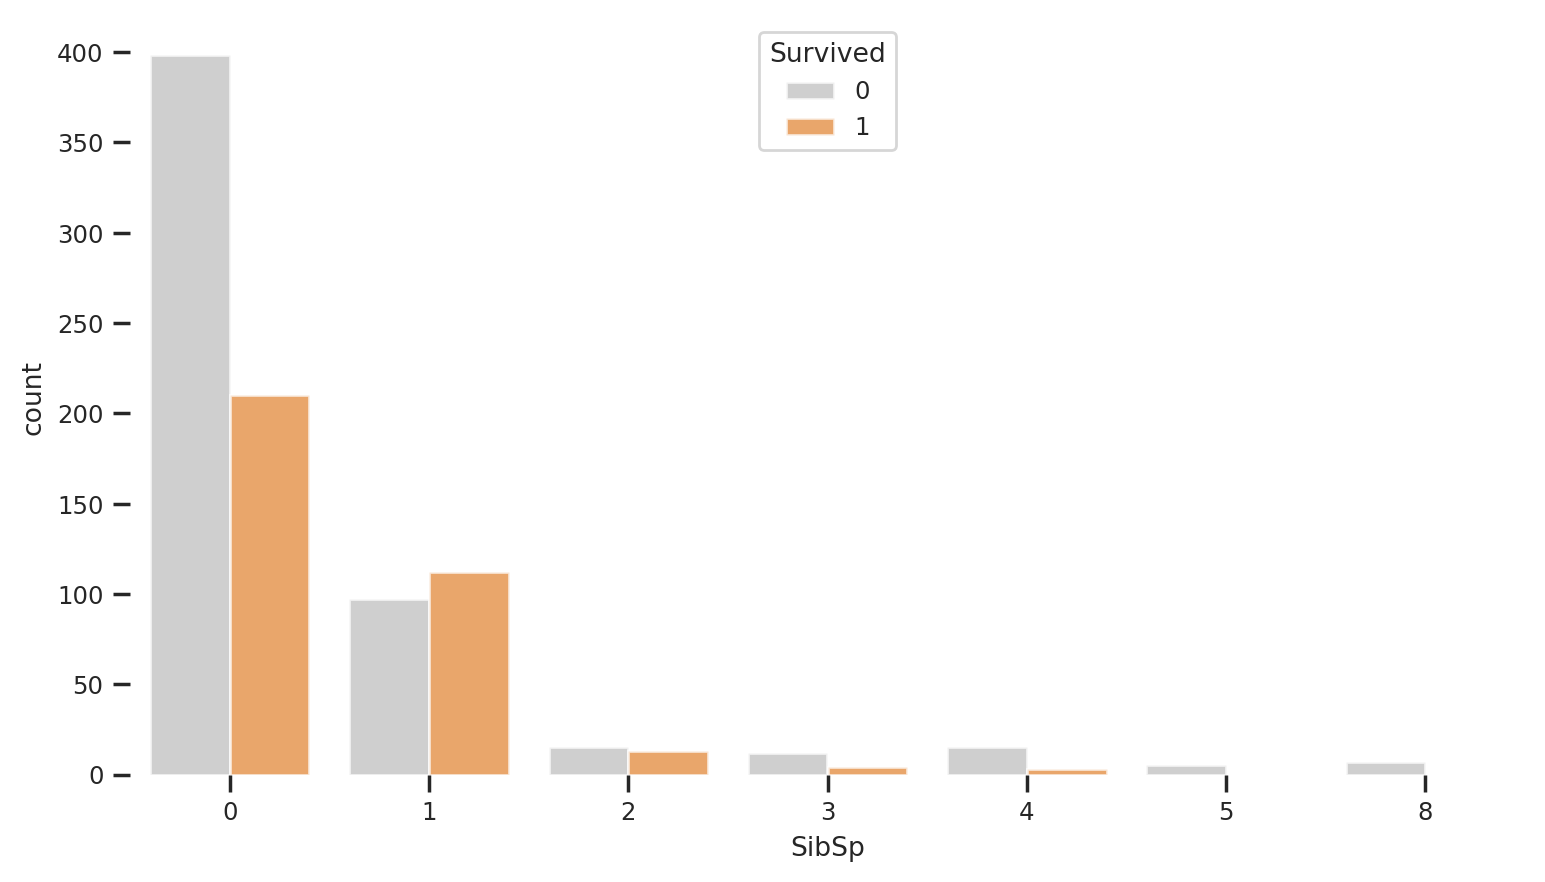

In [25]:
plt.figure(figsize=(9,5))
sns.countplot(data=df, x='SibSp', hue='Survived', alpha=0.7);

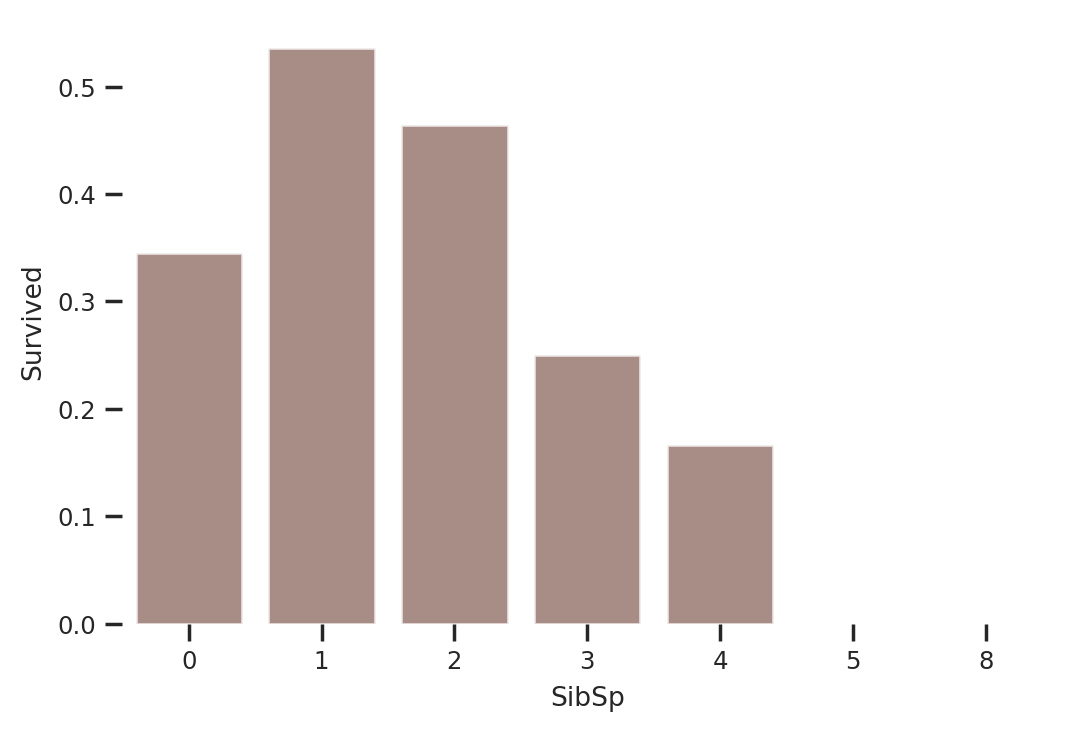

In [26]:
# Compare average survival rate by SibSp
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='SibSp', y='Survived', ci=None, color=cbrown, alpha=0.7);

In [27]:
# Calculate average survival probability by SibSp
df['Survived'].groupby(df['SibSp']).mean()

SibSp
0   0.345
1   0.536
2   0.464
3   0.250
4   0.167
5   0.000
8   0.000
Name: Survived, dtype: float64

**Interpretation:** 
- Passengers with **one** sibling or spouse had a **greater than 50%** chance of surviving.
- Three or greater SibSp relationships resulted in greatly reduced chances of surviving.

### Explore Parch

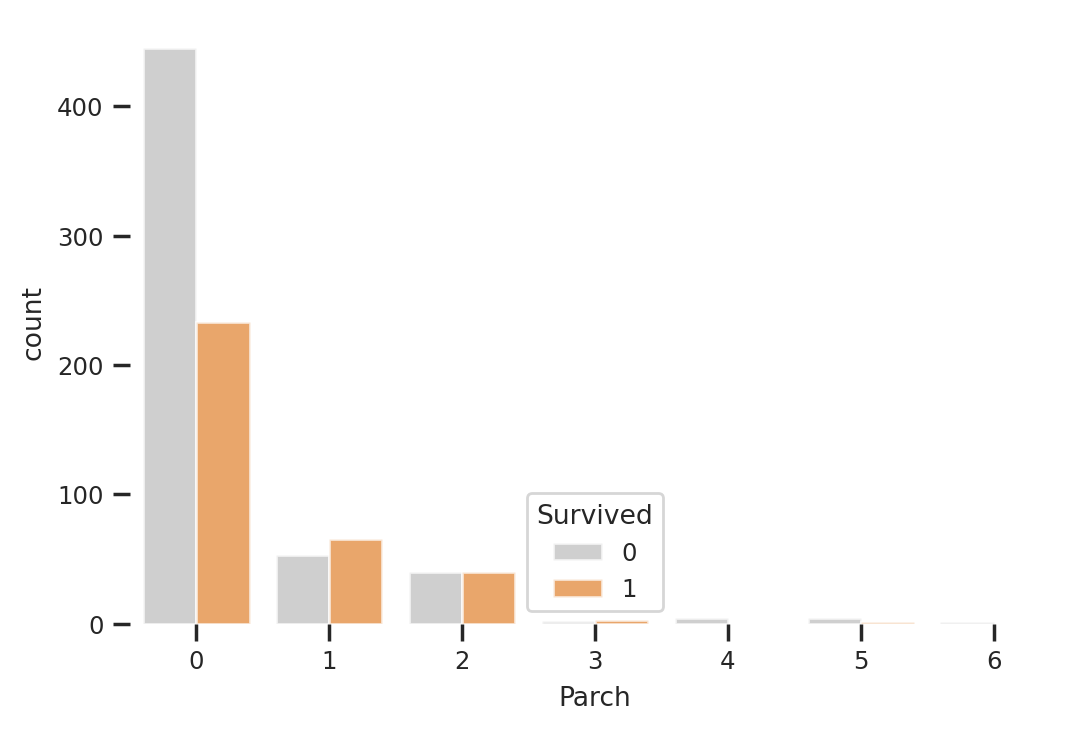

In [28]:
# Count plot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Parch', hue='Survived', alpha=0.7);

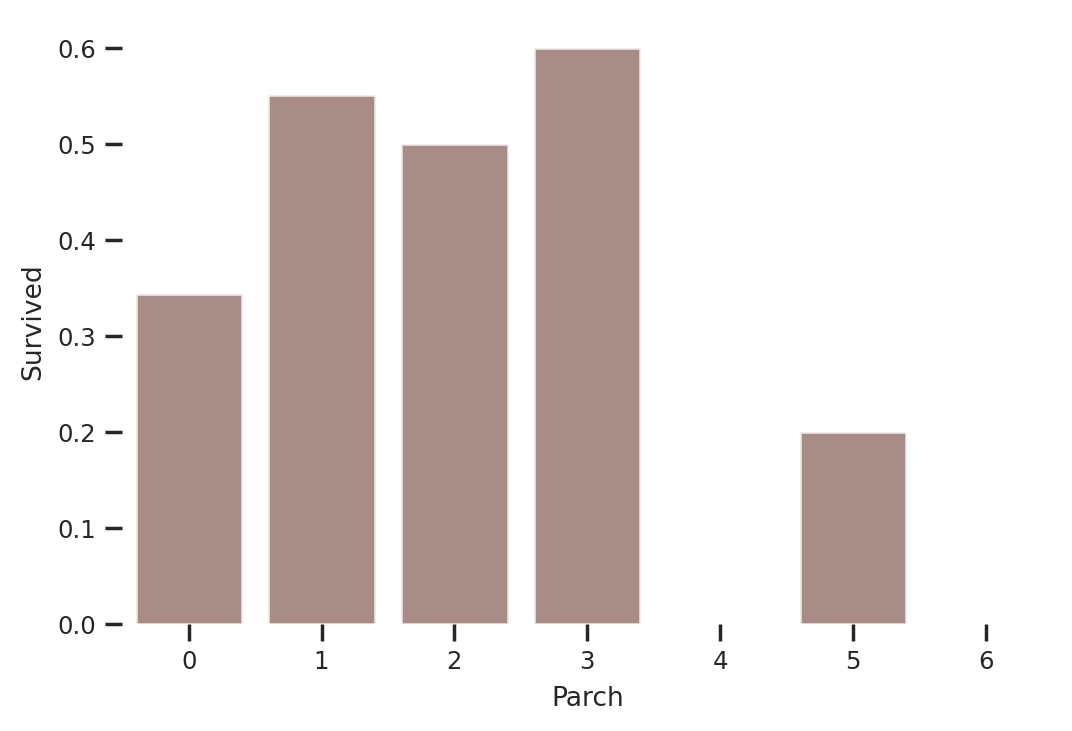

In [29]:
# Compare average survival rate by Parch
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Parch', y='Survived', ci=None, color=cbrown, alpha=0.7);

In [30]:
# Calculate average survival probability by Parch
df['Survived'].groupby(df['Parch']).mean()

Parch
0   0.344
1   0.551
2   0.500
3   0.600
4   0.000
5   0.200
6   0.000
Name: Survived, dtype: float64

**Interpretation:** Passengers with **one, two, or three** siblings/spouses had a **50% or greater** chance of surviving.

### Ordinal Variable Summary
- **Pclass** is highly relevant to predicting survival, with lower Pclass numbers corresponding with lower death probability. No null values.
- **SibSp** and **Parch** both seem relevant to predicting survival, with one sibling/spouse and/or one parent/child relationship correlating with higher survival probability. No null values.
- Given the similarity between the fields, as well as their fairly strong correlation, we should probably combine **SibSp** and **Parch** into one new variable.

# Clean Ordinal Data

- Combine SibSp and Parch into one new variable: `Family_cnt`
- Drop SibSp and Parch.

### Create Family_cnt
We can reduce the complexity of our data set and enhance the likely success of our data modeling by combining SibSp and Parch into one variable, the total of SibSp + Parch.

In [31]:
# Create Family_cnt
df['Family_cnt'] = df['SibSp'] + df['Parch']
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_cnt
0,0,3,male,22.000,1,0,7.250,NaN,S,1
1,1,1,female,38.000,1,0,71.283,C85,C,1
2,1,3,female,26.000,0,0,7.925,NaN,S,0
3,1,1,female,35.000,1,0,53.100,C123,S,1
4,0,3,male,35.000,0,0,8.050,NaN,S,0


In [32]:
# View the original columns plus the new side by side
df[['SibSp','Parch','Family_cnt']].sort_values('Family_cnt', ascending=False).head(20)

,SibSp,Parch,Family_cnt
180,8,2,10
846,8,2,10
792,8,2,10
201,8,2,10
159,8,2,10
863,8,2,10
324,8,2,10
386,5,2,7
59,5,2,7
678,1,6,7


### Explore new `Family_cnt` variable

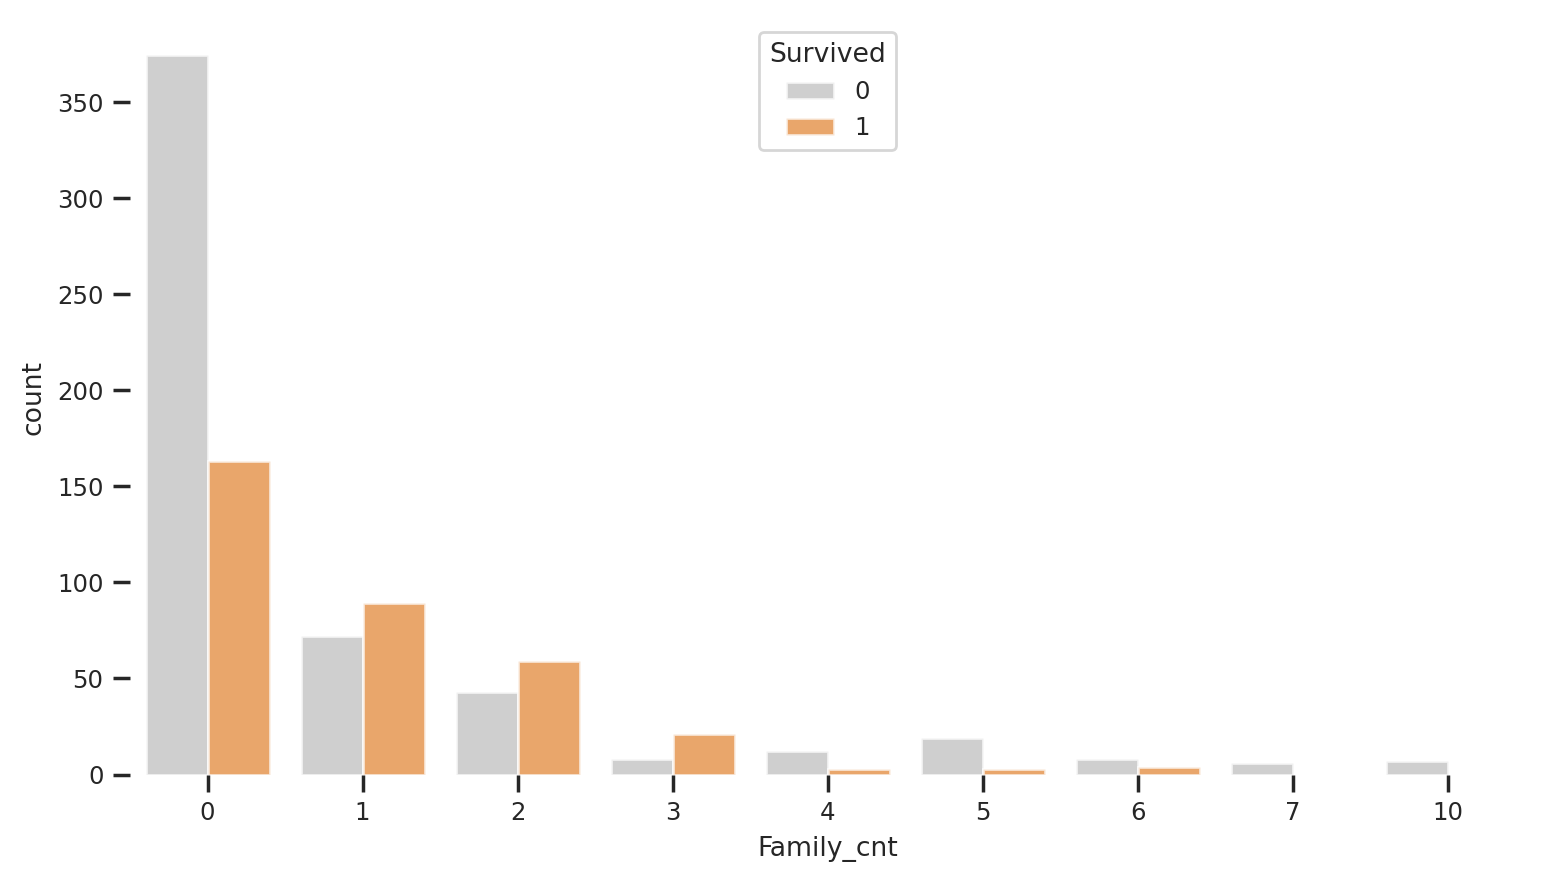

In [33]:
plt.figure(figsize=(9,5))
sns.countplot(data=df, x='Family_cnt', hue='Survived', alpha=0.7);

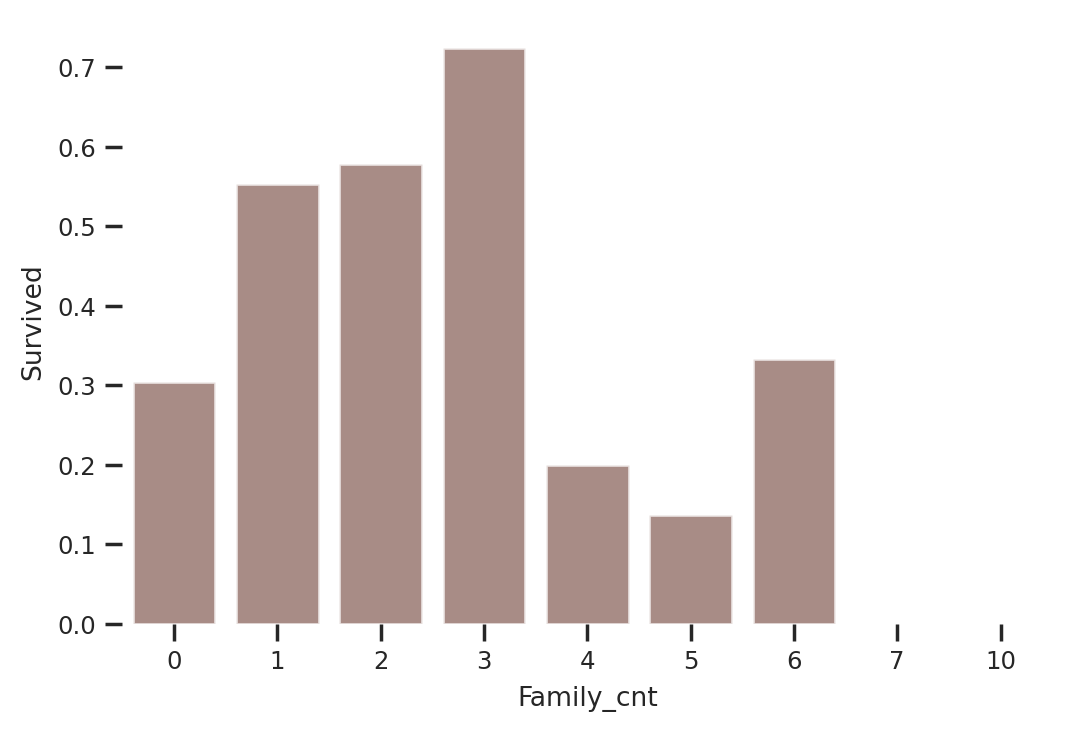

In [34]:
# Compare average survival rate by Family_cnt
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Family_cnt', y='Survived', ci=None, color=cbrown, alpha=0.7);

In [35]:
# Calculate average survival probability by Family_cnt
df['Survived'].groupby(df['Family_cnt']).mean()

Family_cnt
0    0.304
1    0.553
2    0.578
3    0.724
4    0.200
5    0.136
6    0.333
7    0.000
10   0.000
Name: Survived, dtype: float64

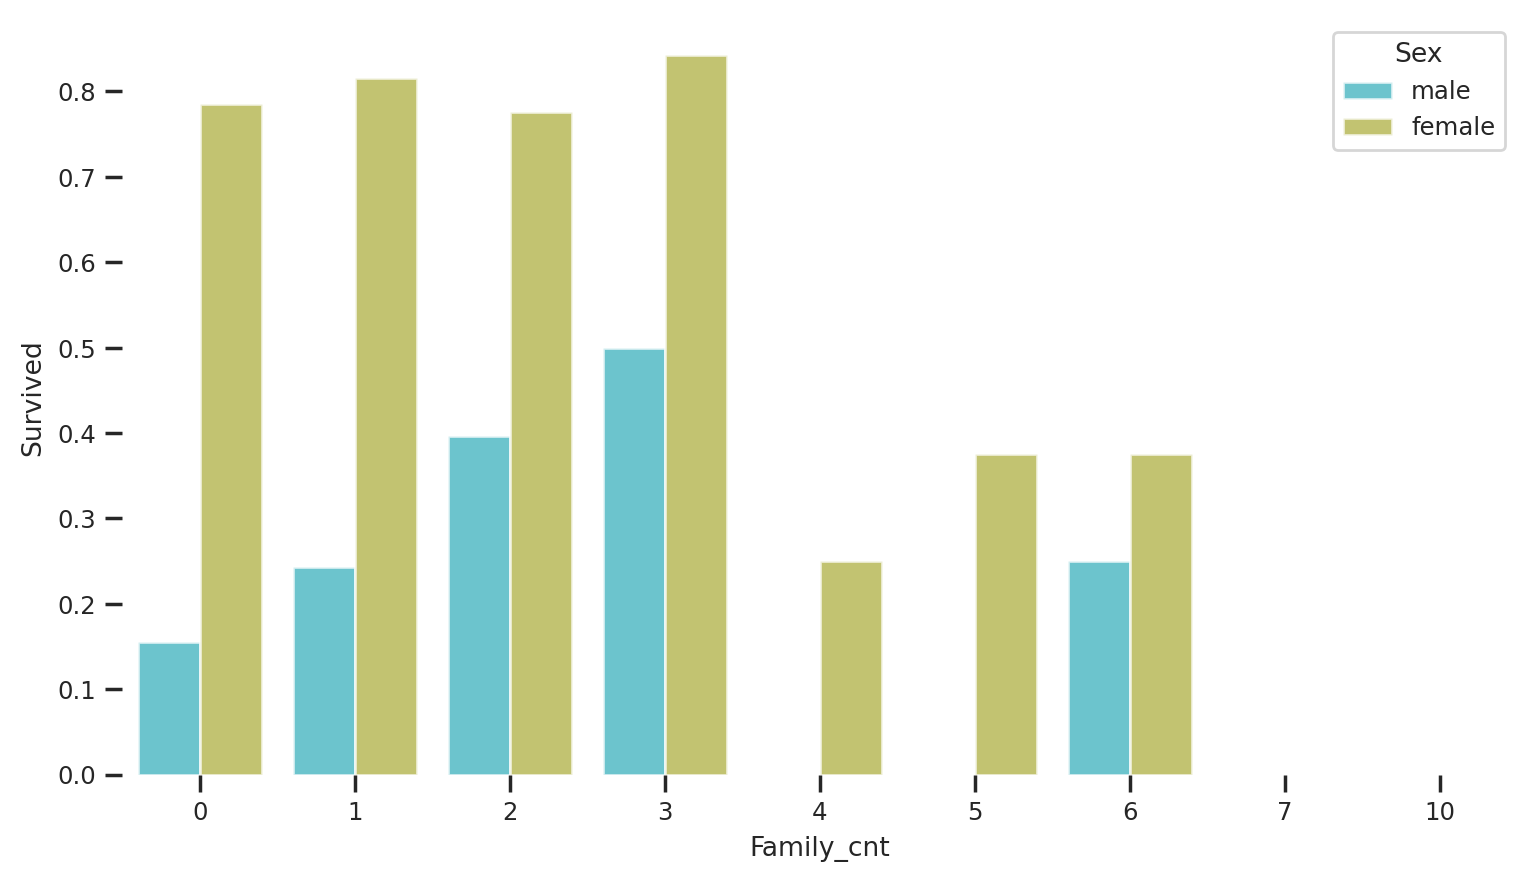

In [36]:
# Compare average survival of Men and Women by Family_cnt
plt.figure(figsize=(9,5))
sns.barplot(data=df, x='Family_cnt', y='Survived', ci=None, palette=cp2, hue='Sex', alpha=0.7);

**Intepretation:** 
- This calculated field has added value to our data set!
- Passengers with 1, 2, or 3 family relations were more likely to survive than not.
- Those with exactly three had a **72%** chance of survival!

### Drop `SibSp` & `Parch`
These are now redundant with `Family_cnt`.

In [37]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_cnt
0,0,3,male,22.000,1,0,7.250,NaN,S,1
1,1,1,female,38.000,1,0,71.283,C85,C,1
2,1,3,female,26.000,0,0,7.925,NaN,S,0
3,1,1,female,35.000,1,0,53.100,C123,S,1
4,0,3,male,35.000,0,0,8.050,NaN,S,0


In [38]:
df.drop(['SibSp','Parch'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Family_cnt
0,0,3,male,22.000,7.250,NaN,S,1
1,1,1,female,38.000,71.283,C85,C,1
2,1,3,female,26.000,7.925,NaN,S,0
3,1,1,female,35.000,53.100,C123,S,1
4,0,3,male,35.000,8.050,NaN,S,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Cabin       204 non-null    object 
 6   Embarked    889 non-null    object 
 7   Family_cnt  891 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


# Explore & Plot Categorical Features

In [40]:
cat = ['Survived','Sex','Cabin','Embarked']
df[cat].head()

,Survived,Sex,Cabin,Embarked
0,0,male,NaN,S
1,1,female,C85,C
2,1,female,NaN,S
3,1,female,C123,S
4,0,male,NaN,S


In [41]:
df[cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  891 non-null    int64 
 1   Sex       891 non-null    object
 2   Cabin     204 non-null    object
 3   Embarked  889 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.0+ KB


In [42]:
# Count nulls
df[cat].isnull().sum()

Survived      0
Sex           0
Cabin       687
Embarked      2
dtype: int64

### Explore the variable `Sex`
How does survival probability differ between male and female passengers?

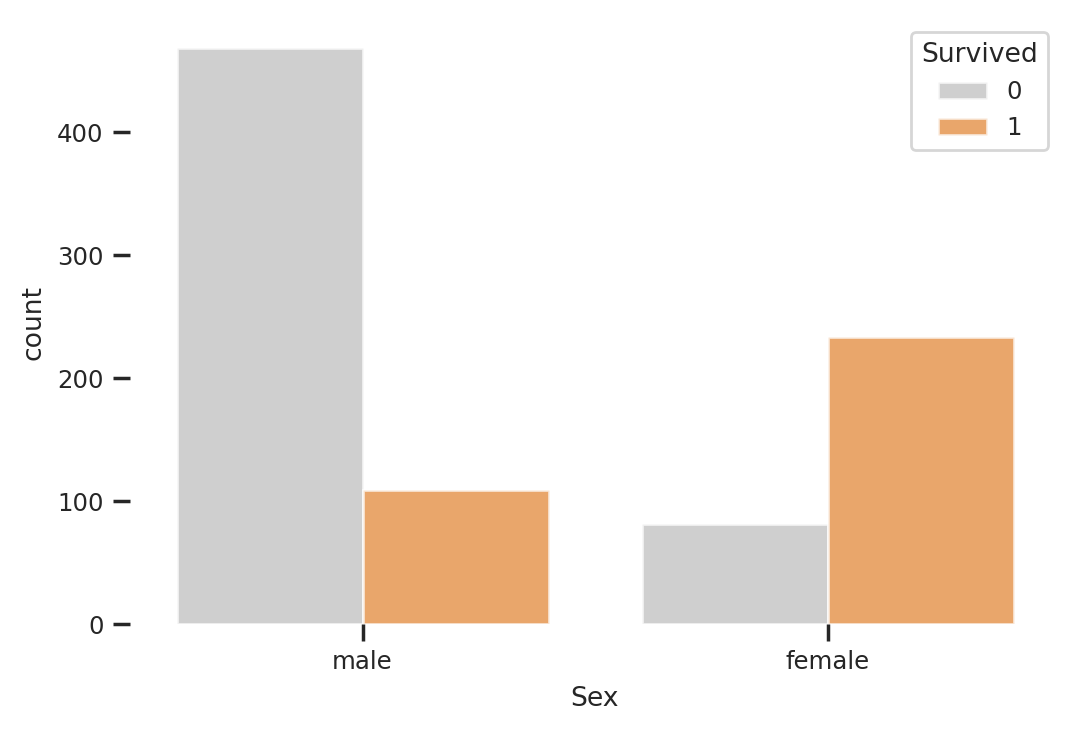

In [43]:
# Comparing proportions of survived vs. non for each sex
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sex', hue='Survived', alpha=0.7);

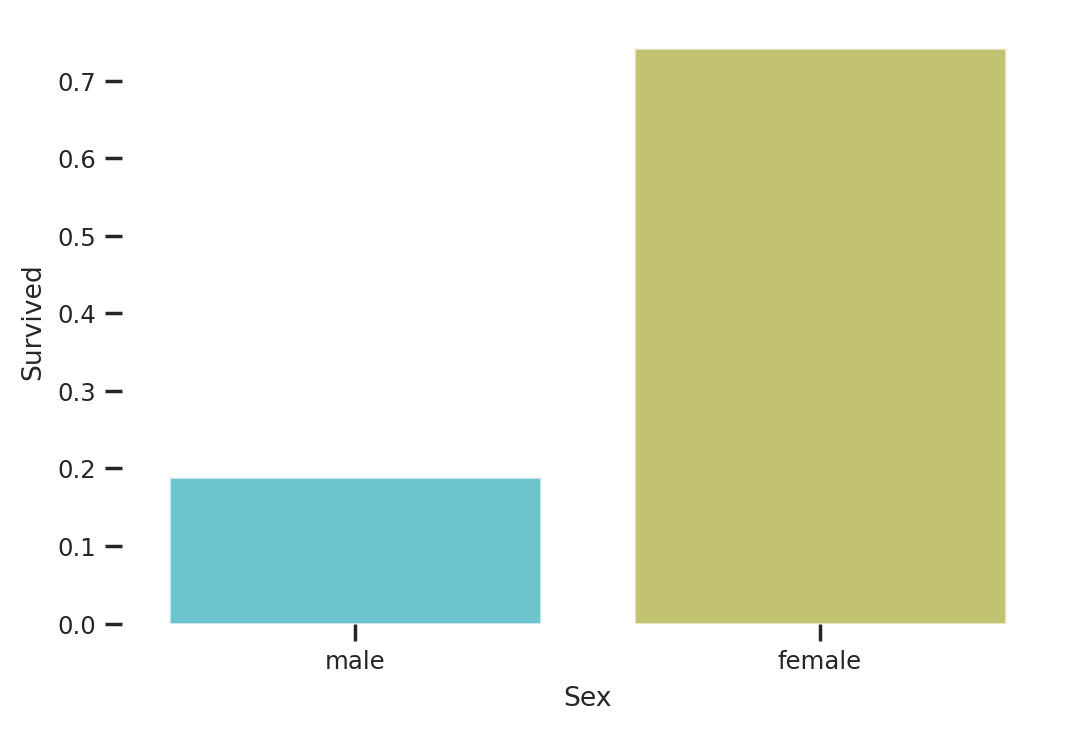

In [44]:
# Compare average survival rate by sex
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Sex', y='Survived', ci=None, palette=cp2, alpha=0.7);

In [45]:
# View an average of survival by Sex
df['Survived'].groupby(df['Sex']).mean()

Sex
female   0.742
male     0.189
Name: Survived, dtype: float64

**Interpretation:** **Women had a survival rate of 74.2%**, while that for men was only 18.9%.

### Explore `Cabin`
As we know, the Cabin field has 687 null values out of 891 records. We need to examine to see if there are any similarities between survival rates for those with null values vs. those with non-null values.

In [46]:
# View an average of survival by whether Cabin is null
df['Survived'].groupby(df['Cabin'].isnull()).mean()

Cabin
False   0.667
True    0.300
Name: Survived, dtype: float64

**Interpretation:**
- Passengers with a non-null value for Cabin had a **66.7%** survival rate.
- Those with a null value had only a **29.9%** survival rate.

**_The presence or absence of a Cabin is of major predictive value!_**

### Create `Cabin_ind`
- 0 = no assigned cabin (null)
- 1 = assigned cabin (non-null)

In [47]:
df['Cabin_ind'] = np.where(df['Cabin'].isnull(), 0, 1)
df[['Cabin','Cabin_ind']].sample(10)

,Cabin,Cabin_ind
555,NaN,0
820,B69,1
808,NaN,0
247,NaN,0
457,D21,1
324,NaN,0
494,NaN,0
870,NaN,0
489,NaN,0
108,NaN,0


### Explore `Cabin_ind`
How strong an indicator of survival probability is it?

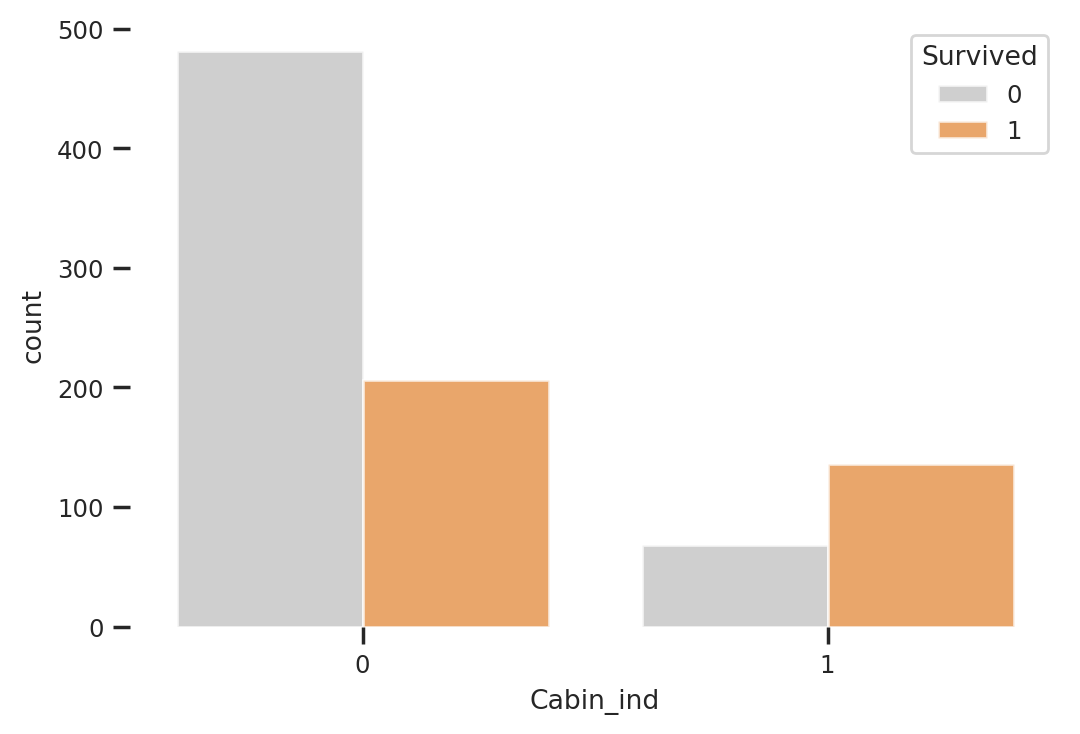

In [48]:
# View the proportions of survived vs non by cabin_ind
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Cabin_ind', hue='Survived', alpha=0.7);

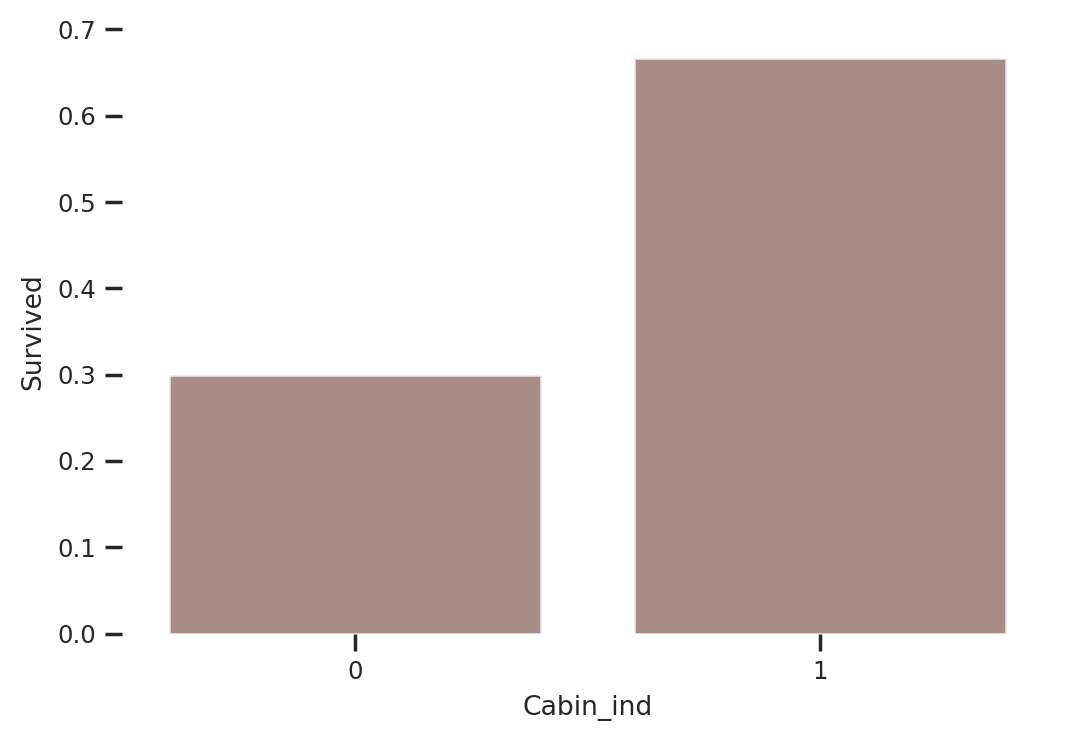

In [49]:
# Compare average survival rate by Cabin_ind
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Cabin_ind', y='Survived', ci=None, color=cbrown, alpha=0.7);

**Interpretation:** Those with cabins had a near 70% survival rate, compared to only 30% for those without.

In [50]:
# Again, here are the exact proportions of survivors by Cabin_ind
df['Survived'].groupby(df['Cabin_ind']).mean()

Cabin_ind
0   0.300
1   0.667
Name: Survived, dtype: float64

### Explore `Embarked`
- There are 2 null values.
- More important: We need to see if it is a likely indicator of survival probability.

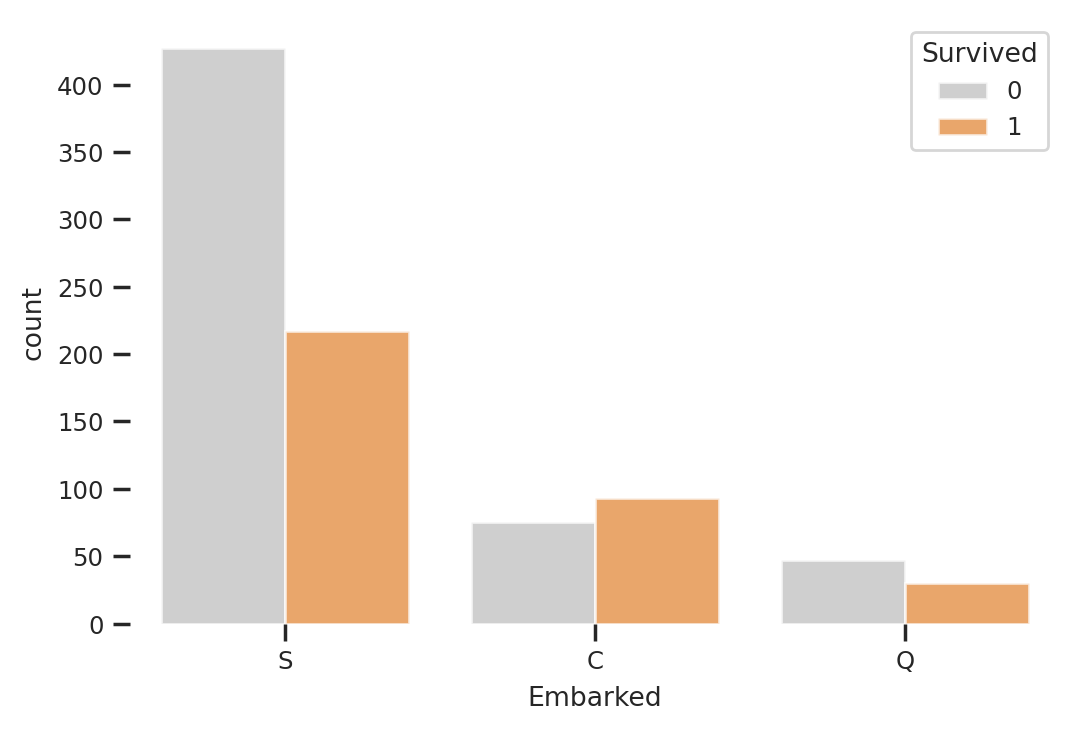

In [51]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Embarked', hue='Survived', alpha=0.7);

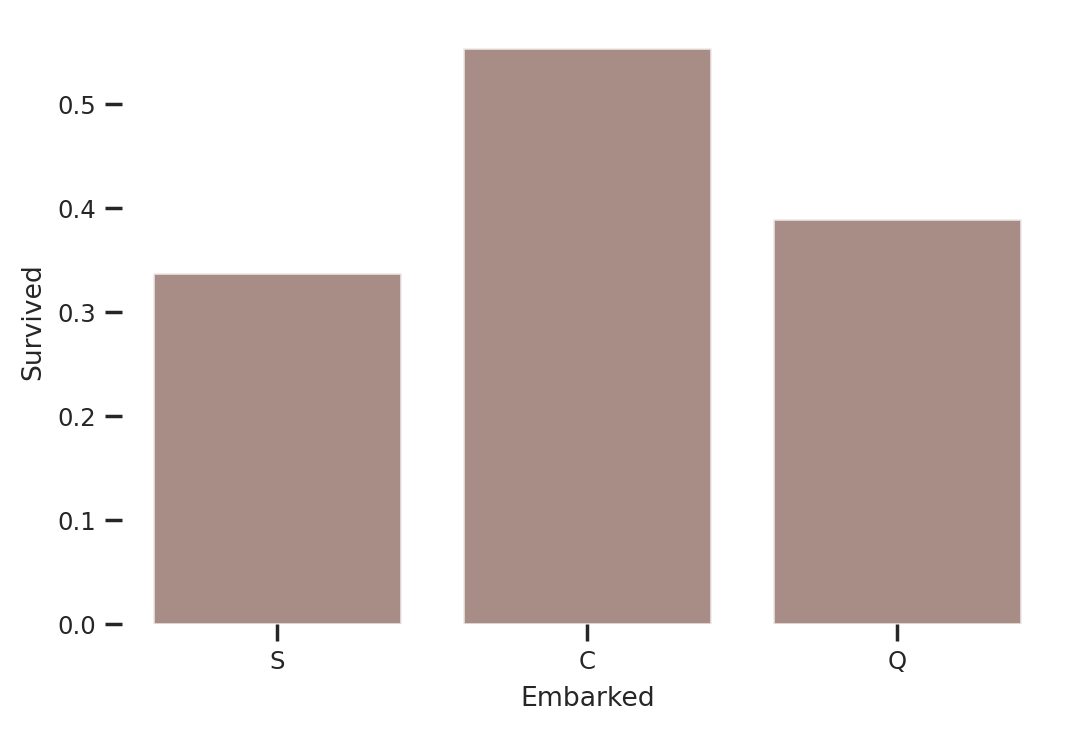

In [52]:
# Compare average survival rate by Embarked
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Embarked', y='Survived', ci=None, color=cbrown, alpha=0.7);

In [53]:
# Calculate average survival probability by Parch
df['Survived'].groupby(df['Embarked']).mean()

Embarked
C   0.554
Q   0.390
S   0.337
Name: Survived, dtype: float64

**Interpretation:** 
- Those embarking from **Cherbourg** had a 55.3% survival rate.
- **Queenstown** 39%.
- **Southampton** only 33.7%.

**Questions:**
- Did embarking from Cherbourg *cause* or *influence* a greater likelihood of survival?
- Or is there correlation here between this and other clearly influencial variables like `Sex` or `Pclass`?

### Create a pivot table to view distribution of sex for embarkation points

In [54]:
df.pivot_table('Survived', index='Sex', columns='Embarked', aggfunc='count')

Embarked,C,Q,S
Sex,,,
female,73,36,203
male,95,41,441


**Interpretation:** The much higher proportion of men departing from Southampton helps explain the higher proportion of fatalities. Similarly, the closer ratios for Cherbourg and Queenstown help explain the closer probabilities of survival. 

### Pivot table to view distribution of Cabin_ind for embarkation points

In [55]:
df.pivot_table('Survived', index='Cabin_ind', columns='Embarked', aggfunc='count')

Embarked,C,Q,S
Cabin_ind,,,
0,99,73,515
1,69,4,129


**Conclusion:** **Embarked** is not a strong indicator of survival probability. We can remove it from the data set.

### Categorical Variable Summary
- `Sex` is a strong indicator. Keep it. No nulls.
- `Cabin` should be replaced with `Cabin_ind` — which is a very strong indicator.
- `Embarked` should be dropped, as it is not a strong indicator.

# Clean Categorical Data
- Convert `Sex` to a numeric indicator.
- Drop unneeded columns.

### Convert `Sex` to a numeric indicator
Necessary to prepare for machine learning.
- 0 = male
- 1 = female

In [56]:
gender_map = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(gender_map)
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Family_cnt,Cabin_ind
0,0,3,0,22.000,7.250,NaN,S,1,0
1,1,1,1,38.000,71.283,C85,C,1,1
2,1,3,1,26.000,7.925,NaN,S,0,0
3,1,1,1,35.000,53.100,C123,S,1,1
4,0,3,0,35.000,8.050,NaN,S,0,0


### Drop Cabin and Embarked:
- Cabin is not useful in itself and now replaced by Cabin_ind.
- Embarked is redundant with other variables and likely not useful for prediction.

In [57]:
df.drop(['Cabin','Embarked'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Fare,Family_cnt,Cabin_ind
0,0,3,0,22.000,7.250,1,0
1,1,1,1,38.000,71.283,1,1
2,1,3,1,26.000,7.925,0,0
3,1,1,1,35.000,53.100,1,1
4,0,3,0,35.000,8.050,0,0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Family_cnt  891 non-null    int64  
 6   Cabin_ind   891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


# Machine Learning Setup
* Declare global variables
* Define functions for model fitting and evaluation

In [59]:
# Specify random seed value to ensure results are reproducible
# See: https://towardsdatascience.com/how-to-use-random-seeds-effectively-54a4cd855a79
seed = 42

# Set up basic components for training using GridSearch

# Empty list to hold our best models
models = []

# Number of splits for k-fold cross-validation
k = 5

# Scorers we desire during training from GridSearchCV
# zero_division=1 eliminates unnecessary UndefinedMetricWarning see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
scoring = {
            'accuracy': make_scorer(accuracy_score),
            'recall': make_scorer(recall_score),
            'precision': make_scorer(precision_score, zero_division=1),
            'roc_auc': make_scorer(roc_auc_score, greater_is_better=True,
                     needs_threshold=False),
            'f1': make_scorer(f1_score, zero_division=1)
          }

# Metrics that we desire for report of GridSearchCV results
metrics = ['params',
           'mean_test_accuracy',
           'mean_test_precision',
           'mean_test_recall', 
           'mean_test_roc_auc',
           'mean_test_f1'
          ]

# Define function for cross-validation, reporting, and storing top model to models list

def crossval_func(name, algorithm, param_grid, priority_score):
    cv = GridSearchCV(
                estimator = algorithm,
                param_grid = param_grid, 
                scoring = scoring,
                refit = priority_score, 
                cv = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)
             )

    # Keep track of training time
    start = time()

    # Activate gridsearch
    cv.fit(tr_features, tr_labels)

    end = time()
    latency = round((end-start), 2)

    # Store top model to models list
    model = cv.best_estimator_
    params = cv.best_params_
    score = round(cv.best_score_ * 100, 3)
    models.append({'Name': name, 'Params': params, 'Model': model, 'Score': score})
    
    # Create dataframe from gridsearch cv_results_
    cv_results = pd.DataFrame.from_dict(cv.cv_results_)

    # Specify desired data from our results dataframe
    # cv_results_metrics = cv_results.loc[:, metrics]
    cv_results_metrics = cv_results[metrics].copy()

    #  Sort values and reset index
    sortby = 'mean_test_' + priority_score
    cv_results_metrics.sort_values(sortby, ascending=False, inplace=True)

    # Set new index starting at 1 for sorted dataframe
    cv_results_metrics.index = range(1, cv_results_metrics.shape[0] + 1)

    # Report results
    print(f'\nGRIDSEARCH RESULTS')
    print(f'Priority: {priority_score}')
    print()
    print(f'Training Time: {latency}s')
    print()

    howmany = 10
    print(f'\n{howmany} BEST-PERFORMING {name} MODELS')
    print(f'ranked by {sortby}')
    display(cv_results_metrics.head(howmany))

    print(f'\nTOP MODEL: {cv.best_estimator_}')
    print(f'\t{round(cv.best_score_*100, 3)} {priority_score} score')


In [60]:
# List to hold scores for each model
scoreslist = []

scorenames = ['Accuracy',
              'Precision',
              'Recall',
              'ROC AUC',
              'F1 Score'
             ]


# Define function to record and report scores
def record_scores(name, model, features, labels):
    '''
    name = model name
    model = model variable
    features = features of desired split
    labels = labels of desired split
    '''
    predictions = model.predict(features)

    scores = [accuracy_score(labels, predictions),
              precision_score(labels, predictions),
              recall_score(labels, predictions),
              roc_auc_score(labels, predictions),
              f1_score(labels, predictions)
             ]

    
    # Create list with model name, model, and scores
    modelscores = []
    modelscores.append(name)
    for score in scores:
        modelscores.append(score)

    scoreslist.append(modelscores)

# Define function to score all models and report results
def score_models(models_list, features, labels, priority='Accuracy'):
    # Score all models with test split
    for model in models:
        record_scores(model['Name'], model['Model'], features, labels)

    # Store to dataframe, including melted version of dataframe for visualization
    tsdf = pd.DataFrame(scoreslist, columns = ['Model'] + scorenames)
    tsdf = tsdf.sort_values(priority, ascending=False).copy()
    tsdf_melt = pd.melt(tsdf, id_vars="Model", var_name="Metric", value_name="Score")
    tsdf_melt
    tsdf.set_index('Model', inplace=True)

    # Display the dataframe
    display(tsdf)

    # Barplot
    plot_height = len(models) * 1.5
    plt.figure(figsize=(6,plot_height))
    # plt.title('Model Scores', fontweight='bold', fontsize=12)
    sns.barplot(data=tsdf_melt, y='Metric', x='Score', hue='Model', palette=cp3).set(ylabel=None);
    
# Define a function to generate confusion matrices
def make_cm(name, model, features, labels):
    '''
    name = model name
    model = model variable
    features = features of desired split
    labels = labels of desired split
    '''
    predictions = model.predict(features)
    cm = confusion_matrix(labels, predictions)
    cm_norm = confusion_matrix(labels, predictions, normalize='true')

    # Generate plot
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm_norm.flatten()]
    group_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_percentages, group_counts)]
    group_labels = np.asarray(group_labels).reshape(2,2)
    plt.figure(figsize = (4,3))
    plt.title(f'\n{name} Confusion Matrix\n', fontsize=11, fontweight='bold')
    sns.heatmap(cm, annot=group_labels, fmt='', cmap='Blues', annot_kws={"size": 10}, cbar=None); # NOTE: fmt='' is required! 
    
# Define function to generate confusion matrices for all models
def generate_cms(models_list, features, labels):
    for model in models:
        make_cm(model['Name'], model['Model'], features, labels)

# Split into Train and Test Sets (70/30)
See the [train_test_split docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

- Train = 70%
- Validation = 30%

In [61]:
# All Features
all_features = df.drop('Survived', axis=1)

# All Labels
all_labels = df['Survived']

# Create 70/30 split: 70% training, 30% test
tr_features, test_features, tr_labels, test_labels = train_test_split(all_features, all_labels, test_size=0.3, random_state=seed)

# Report the number of records and labels in each new split:
print('Training Features, Labels:')
print(f'{tr_features.shape[0]} Records, {len(tr_labels)} Labels')
print('-----------')
print('Test Features, Labels:')
print(f'{test_features.shape[0]} Records, {len(test_labels)} Labels')

Training Features, Labels:
623 Records, 623 Labels
-----------
Test Features, Labels:
268 Records, 268 Labels


## Logistic Regression ROC_AUC: Train and Tune 
### Prioritizing Accuracy
- [GridSearchCV Docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [LogisticRegression Docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [62]:
# Specify Algorithm shortname
name = 'LR'

# Specify algorithm with desired default parameters
algorithm = LogisticRegression(random_state=seed, fit_intercept=False, max_iter=500, n_jobs=-1)

# Set parameters for GridSearch, to identify best parameters
param_grid = {
    'C': [.001, .01, 1, 10, 100, 1000]
}

# Set priority score for selecting best model
priority_score = 'accuracy'

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, param_grid, priority_score)


GRIDSEARCH RESULTS
Priority: accuracy

Training Time: 1.86s


10 BEST-PERFORMING LR MODELS
ranked by mean_test_accuracy


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1
1,{'C': 10},0.799,0.756,0.688,0.776,0.719
2,{'C': 100},0.799,0.756,0.688,0.776,0.719
3,{'C': 1000},0.799,0.756,0.688,0.776,0.719
4,{'C': 1},0.798,0.755,0.684,0.774,0.716
5,{'C': 0.01},0.711,0.806,0.294,0.625,0.429
6,{'C': 0.001},0.693,0.731,0.286,0.610,0.408



TOP MODEL: LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
	79.921 accuracy score


## Random Forest: Train and Tune 
### Prioritizing Accuracy Score

- [Random Forest Classifier Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [63]:
# Execute GridSearch and Report Results

# Specify Algorithm shortname
name = 'RF'

# Specify algorithm with desired default parameters
algorithm = RandomForestClassifier()

# Set parameters for GridSearch, to identify best parameters
param_grid = {
    'max_depth': [2, 4, 8, 16, 32, None],
    'n_estimators': [5, 50, 250]
}

# Set priority score for selecting best model
priority_score = 'accuracy'

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, param_grid, priority_score)


GRIDSEARCH RESULTS
Priority: accuracy

Training Time: 16.15s


10 BEST-PERFORMING RF MODELS
ranked by mean_test_accuracy


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1
1,"{'max_depth': 8, 'n_estimators': 250}",0.833,0.836,0.688,0.803,0.753
2,"{'max_depth': 8, 'n_estimators': 50}",0.831,0.839,0.688,0.802,0.752
3,"{'max_depth': 4, 'n_estimators': 250}",0.825,0.857,0.653,0.789,0.733
4,"{'max_depth': 4, 'n_estimators': 50}",0.822,0.847,0.653,0.787,0.728
5,"{'max_depth': 16, 'n_estimators': 250}",0.822,0.794,0.705,0.798,0.745
6,"{'max_depth': None, 'n_estimators': 250}",0.820,0.788,0.705,0.796,0.743
7,"{'max_depth': 4, 'n_estimators': 5}",0.819,0.825,0.662,0.786,0.727
8,"{'max_depth': 8, 'n_estimators': 5}",0.817,0.796,0.679,0.789,0.731
9,"{'max_depth': 32, 'n_estimators': 250}",0.817,0.785,0.701,0.793,0.739
10,"{'max_depth': 16, 'n_estimators': 50}",0.817,0.783,0.705,0.794,0.740



TOP MODEL: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
	83.292 accuracy score


## Multi-Layer Perceptron: Train and Tune 
### Prioritizing Accuracy Score

- [Multi-Layer Perceptron Docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [64]:
# Specify Algorithm shortname
name = 'MLP'

# Specify algorithm with desired default parameters
algorithm = MLPClassifier()

# Set parameters for GridSearch, to identify best parameters
param_grid = {
        'hidden_layer_sizes': [(10,), (50,), (100,)],
        'activation': ['relu', 'tanh', 'logistic'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter':[10000] # Raise from default 200 to avoid max iteration warnings
    }

# Set priority score for selecting best model
priority_score = 'accuracy'

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, param_grid, priority_score)



GRIDSEARCH RESULTS
Priority: accuracy

Training Time: 185.5s


10 BEST-PERFORMING MLP MODELS
ranked by mean_test_accuracy


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1
1,"{'activation': 'logistic', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'max_iter': 10000}",0.810,0.766,0.719,0.792,0.739
2,"{'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 10000}",0.810,0.751,0.749,0.798,0.748
3,"{'activation': 'logistic', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 10000}",0.809,0.765,0.710,0.789,0.735
4,"{'activation': 'logistic', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'max_iter': 10000}",0.806,0.766,0.697,0.783,0.728
5,"{'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 10000}",0.806,0.746,0.740,0.792,0.741
6,"{'activation': 'tanh', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling', 'max_iter': 10000}",0.804,0.789,0.671,0.777,0.716
7,"{'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 10000}",0.804,0.782,0.675,0.777,0.720
8,"{'activation': 'logistic', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 10000}",0.804,0.740,0.740,0.791,0.739
9,"{'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'max_iter': 10000}",0.802,0.747,0.705,0.782,0.725
10,"{'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 10000}",0.801,0.746,0.719,0.784,0.730



TOP MODEL: MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
	81.046 accuracy score


## Gradient Boosting: Train and Tune 
### Prioritizing Accuracy Score

- [Gradient Boosting Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [65]:
# Specify Algorithm shortname
name = 'GBoost'

# Specify algorithm with desired default parameters
algorithm = GradientBoostingClassifier()

# Set parameters for GridSearch, to identify best parameters
param_grid = {
    'max_depth': [5, 50, 250, 500],
    'n_estimators': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

# Set priority score for selecting best model
priority_score = 'accuracy'

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, param_grid, priority_score)


GRIDSEARCH RESULTS
Priority: accuracy

Training Time: 11.7s


10 BEST-PERFORMING GBoost MODELS
ranked by mean_test_accuracy


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1
1,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 9}",0.822,0.863,0.627,0.782,0.723
2,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 7}",0.817,0.880,0.597,0.772,0.706
3,"{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 5}",0.814,0.785,0.696,0.790,0.735
4,"{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 1}",0.814,0.814,0.666,0.783,0.725
5,"{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 9}",0.812,0.771,0.714,0.792,0.739
6,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 5}",0.811,0.886,0.571,0.761,0.690
7,"{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 3}",0.809,0.794,0.666,0.780,0.722
8,"{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 7}",0.807,0.762,0.701,0.785,0.730
9,"{'learning_rate': 10, 'max_depth': 5, 'n_estimators': 1}",0.804,0.786,0.675,0.777,0.718
10,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 3}",0.799,0.902,0.523,0.742,0.656



TOP MODEL: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=9,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
	82.173 accuracy score


## XGBoost: Train and Tune 
### Prioritizing Accuracy Score

- [XGBoost Docs](https://xgboost.readthedocs.io/en/latest/)

In [66]:
# Specify Algorithm shortname
name = 'XGBoost'

# Specify algorithm with desired default parameters
algorithm = XGBClassifier()

# Set parameters for GridSearch, to identify best parameters
param_grid = {
    'max_depth': [5, 50, 250, 500],
    'n_estimators': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

# Set priority score for selecting best model
priority_score = 'accuracy'

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, param_grid, priority_score)


GRIDSEARCH RESULTS
Priority: accuracy

Training Time: 7.6s


10 BEST-PERFORMING XGBoost MODELS
ranked by mean_test_accuracy


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1
1,"{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 3}",0.830,0.832,0.688,0.801,0.751
2,"{'learning_rate': 0.1, 'max_depth': 250, 'n_estimators': 9}",0.828,0.837,0.671,0.796,0.743
3,"{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 9}",0.828,0.837,0.671,0.796,0.743
4,"{'learning_rate': 0.1, 'max_depth': 500, 'n_estimators': 9}",0.828,0.837,0.671,0.796,0.743
5,"{'learning_rate': 0.1, 'max_depth': 500, 'n_estimators': 7}",0.827,0.833,0.671,0.795,0.742
6,"{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 7}",0.827,0.833,0.671,0.795,0.742
7,"{'learning_rate': 0.1, 'max_depth': 250, 'n_estimators': 7}",0.827,0.833,0.671,0.795,0.742
8,"{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 5}",0.827,0.809,0.701,0.801,0.750
9,"{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 9}",0.825,0.810,0.692,0.798,0.745
10,"{'learning_rate': 0.01, 'max_depth': 50, 'n_estimators': 9}",0.825,0.832,0.666,0.792,0.739



TOP MODEL: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=3, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)
	82.977 accuracy score


## LightGBM: Train and Tune 
### Prioritizing Accuracy Score

- [LightGBM Docs](https://lightgbm.readthedocs.io/en/latest/)

In [67]:
# Specify Algorithm shortname
name = 'LightGBM'

# Specify algorithm with desired default parameters
algorithm = LGBMClassifier()

# Set parameters for GridSearch, to identify best parameters
param_grid = {
        'num_leaves':[2,5,10],
        'metric':['auc','binary_logloss'],
        'min_data_in_leaf':[25,50,100,200,400]
        }

# Set priority score for selecting best model
priority_score = 'accuracy'

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, param_grid, priority_score)


GRIDSEARCH RESULTS
Priority: accuracy

Training Time: 3.12s


10 BEST-PERFORMING LightGBM MODELS
ranked by mean_test_accuracy


,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_test_f1
1,"{'metric': 'auc', 'min_data_in_leaf': 25, 'num_leaves': 5}",0.820,0.831,0.653,0.786,0.727
2,"{'metric': 'binary_logloss', 'min_data_in_leaf': 25, 'num_leaves': 5}",0.820,0.831,0.653,0.786,0.727
3,"{'metric': 'auc', 'min_data_in_leaf': 50, 'num_leaves': 10}",0.820,0.810,0.679,0.791,0.736
4,"{'metric': 'binary_logloss', 'min_data_in_leaf': 50, 'num_leaves': 10}",0.820,0.810,0.679,0.791,0.736
5,"{'metric': 'auc', 'min_data_in_leaf': 50, 'num_leaves': 5}",0.819,0.812,0.671,0.788,0.732
6,"{'metric': 'binary_logloss', 'min_data_in_leaf': 50, 'num_leaves': 5}",0.819,0.812,0.671,0.788,0.732
7,"{'metric': 'binary_logloss', 'min_data_in_leaf': 100, 'num_leaves': 10}",0.818,0.792,0.701,0.794,0.743
8,"{'metric': 'binary_logloss', 'min_data_in_leaf': 100, 'num_leaves': 5}",0.818,0.792,0.701,0.794,0.743
9,"{'metric': 'auc', 'min_data_in_leaf': 100, 'num_leaves': 5}",0.818,0.792,0.701,0.794,0.743
10,"{'metric': 'auc', 'min_data_in_leaf': 100, 'num_leaves': 10}",0.818,0.792,0.701,0.794,0.743



TOP MODEL: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=25, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=5, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
	82.01 accuracy score


# Models List

View the top models identified during gridsearch training.

In [68]:
for model in models:
    print(f'{model["Name"]} MODEL {model["Params"]}\n\t Training Score: {model["Score"]}\n')

LR MODEL {'C': 10}
	 Training Score: 79.921

RF MODEL {'max_depth': 8, 'n_estimators': 250}
	 Training Score: 83.292

MLP MODEL {'activation': 'logistic', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'max_iter': 10000}
	 Training Score: 81.046

GBoost MODEL {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 9}
	 Training Score: 82.173

XGBoost MODEL {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 3}
	 Training Score: 82.977

LightGBM MODEL {'metric': 'auc', 'min_data_in_leaf': 25, 'num_leaves': 5}
	 Training Score: 82.01



# Test


- Test our models with the test split.
- Evaluate by top ROC_AUC + Recall scores.

### Resources:
- Scikit Learn Docs: [3.3. Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html)

,Accuracy,Precision,Recall,ROC AUC,F1 Score
Model,,,,,
XGBoost,0.825,0.864,0.685,0.804,0.764
LightGBM,0.825,0.864,0.685,0.804,0.764
MLP,0.817,0.816,0.721,0.803,0.766
LR,0.810,0.800,0.721,0.797,0.758
GBoost,0.795,0.859,0.604,0.767,0.709
RF,0.791,0.809,0.649,0.770,0.720


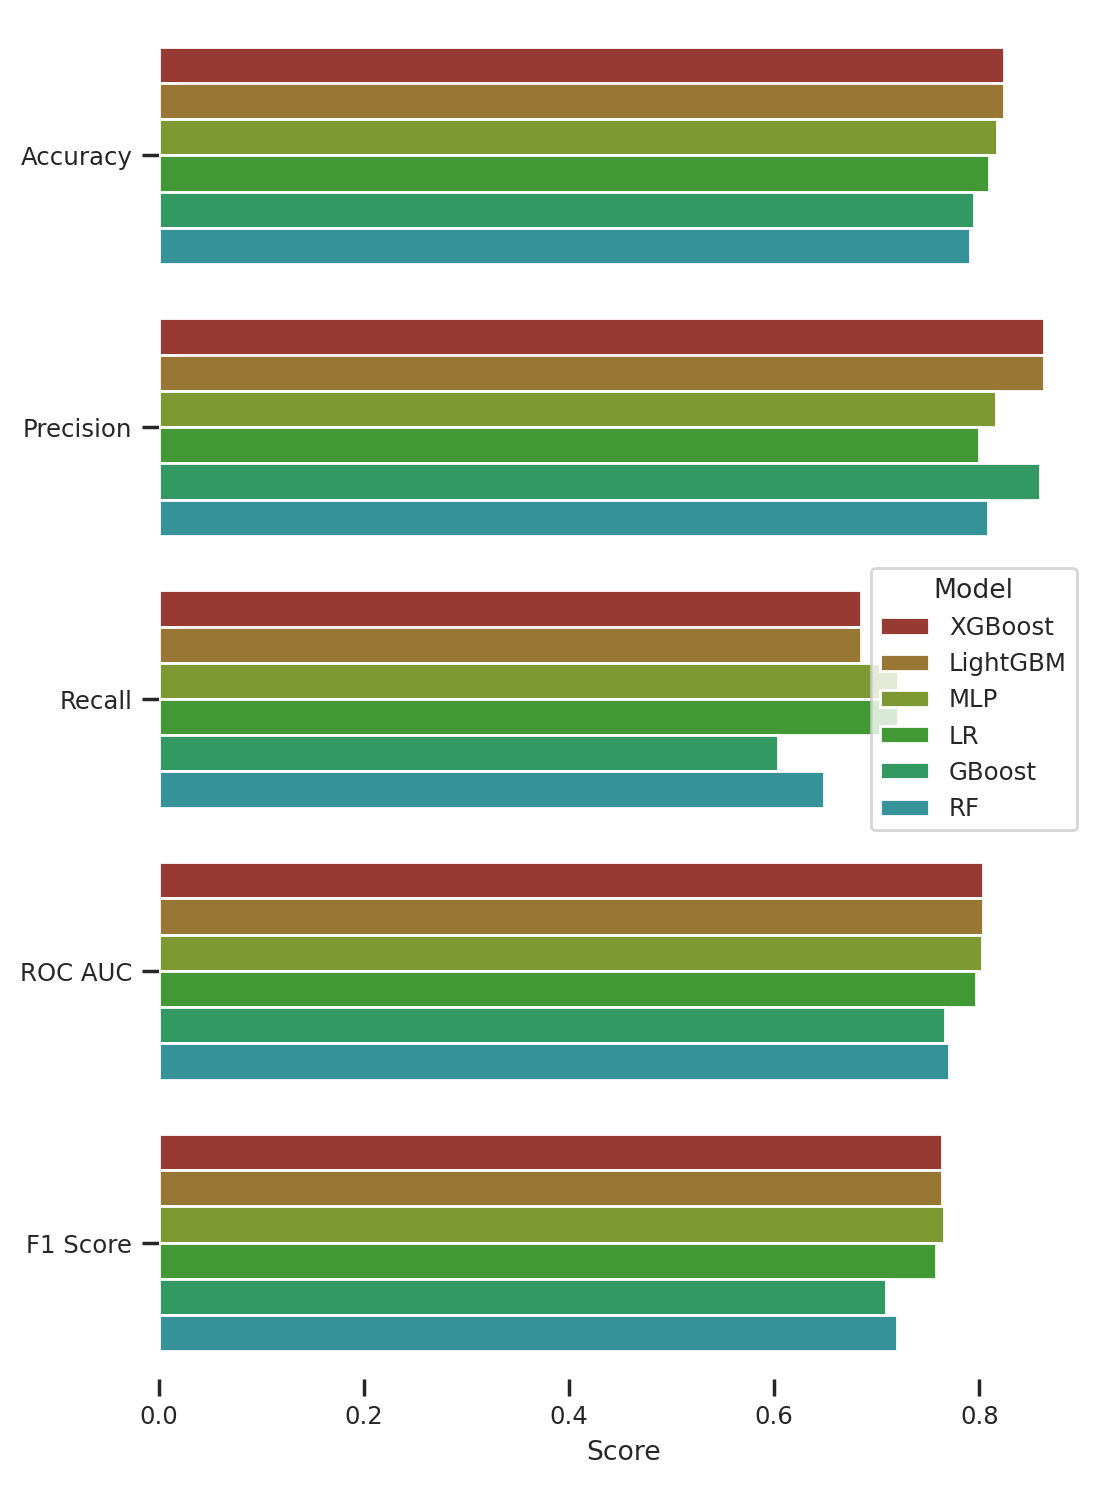

In [69]:
# Score the models on the test set
score_models(models, test_features, test_labels, priority='Accuracy')

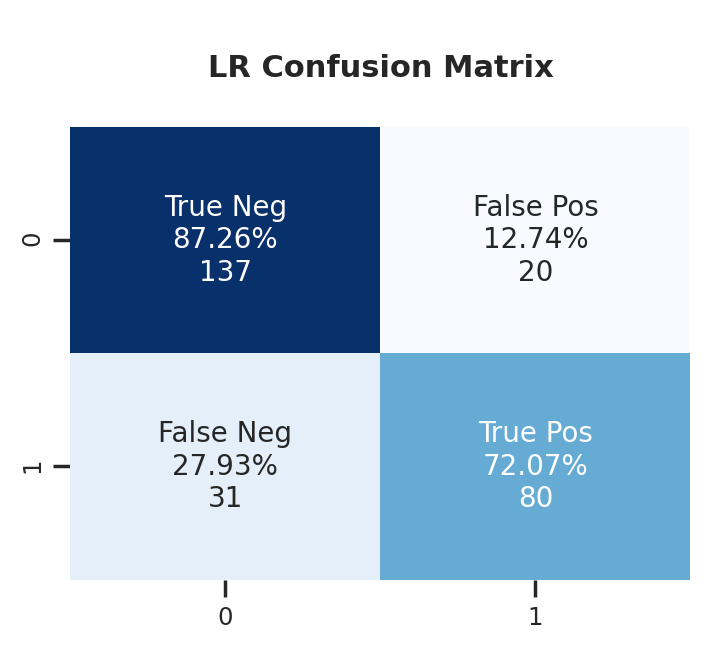

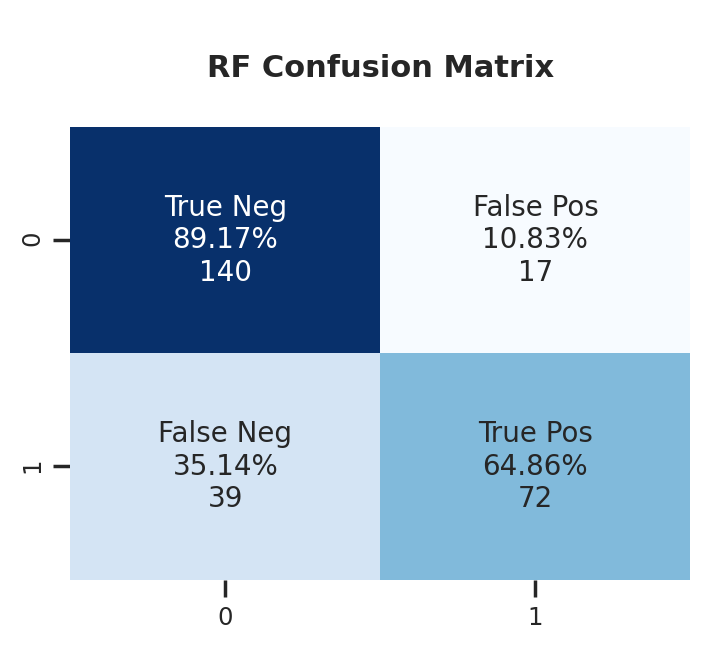

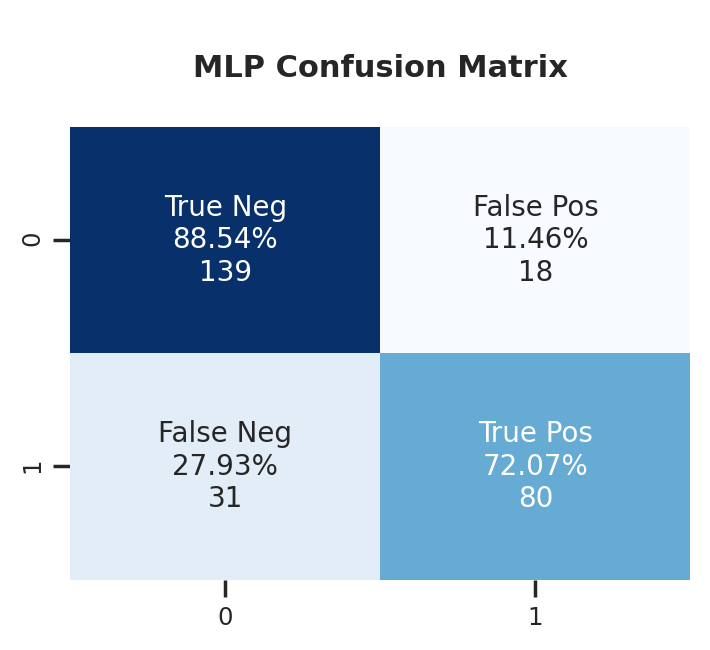

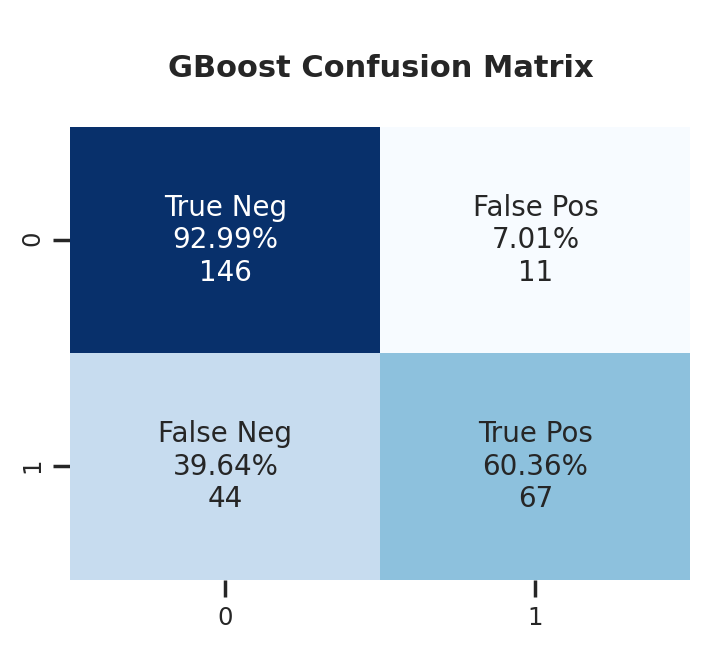

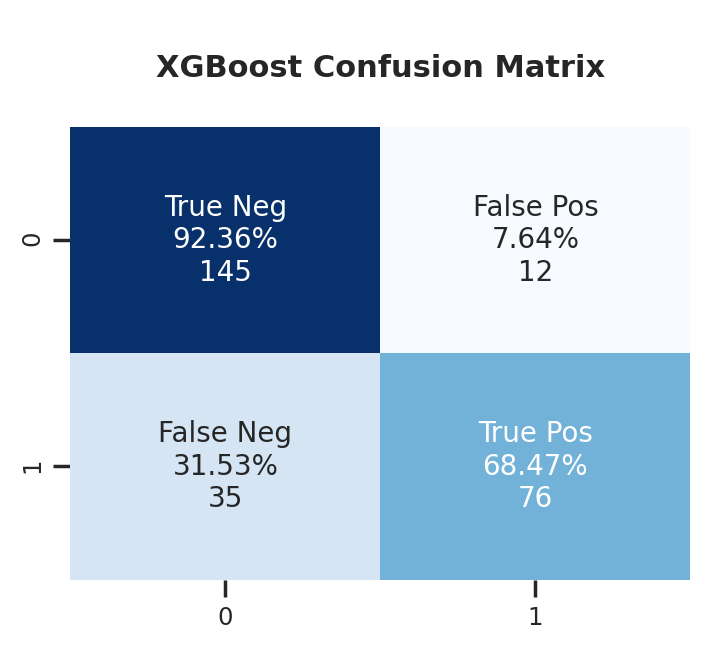

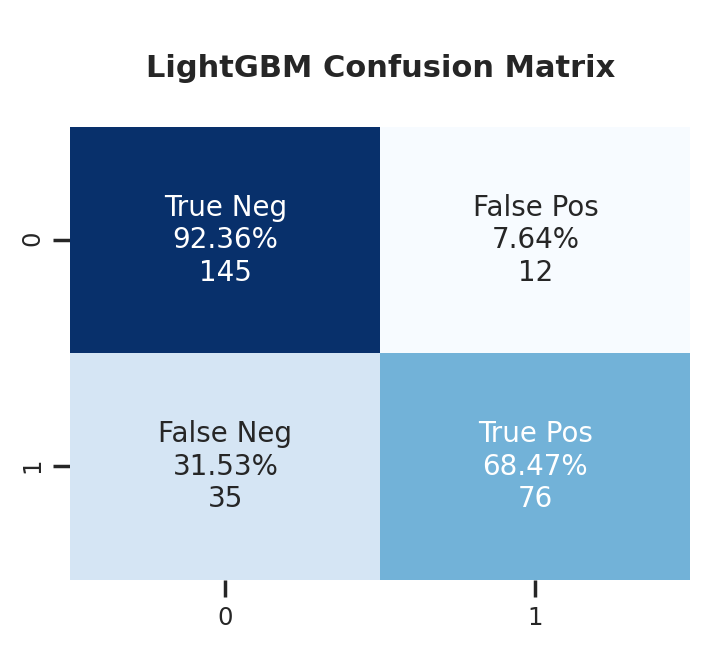

In [70]:
# Generate confusion matrices
generate_cms(models, test_features, test_labels)

## Compare ROC Curves

Resources: 
- https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot 
- https://stats.stackexchange.com/questions/437358/how-to-plot-multiple-classifiers-roc-curves-using-scikitplot
- https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_22_0.html


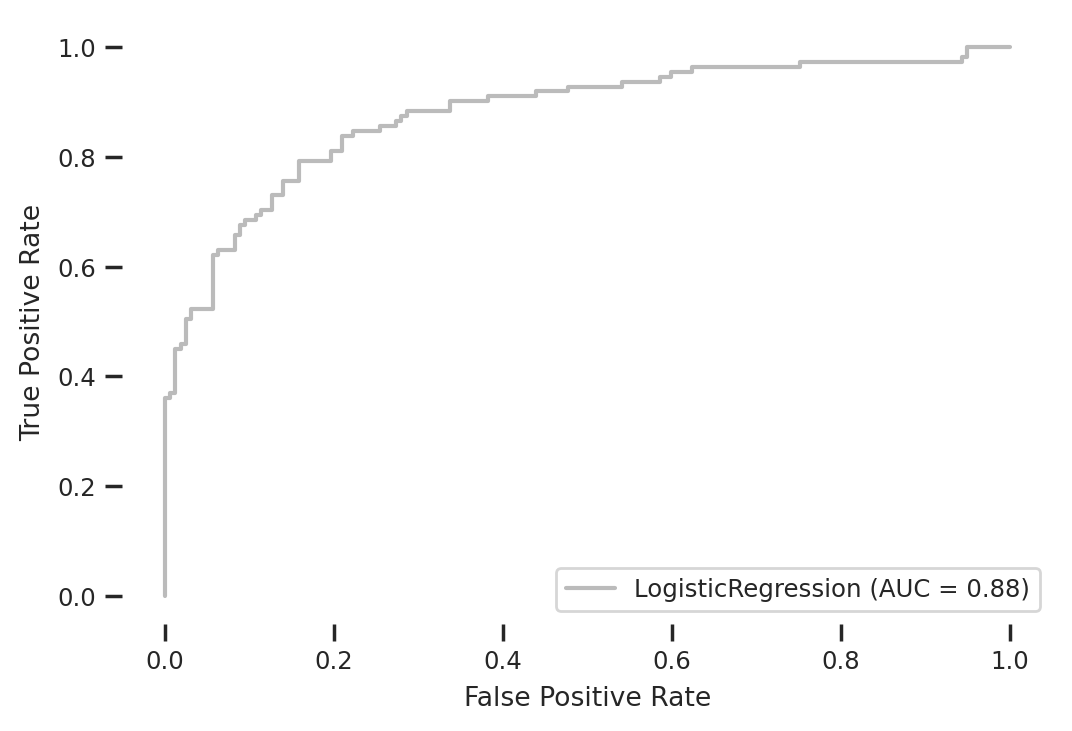

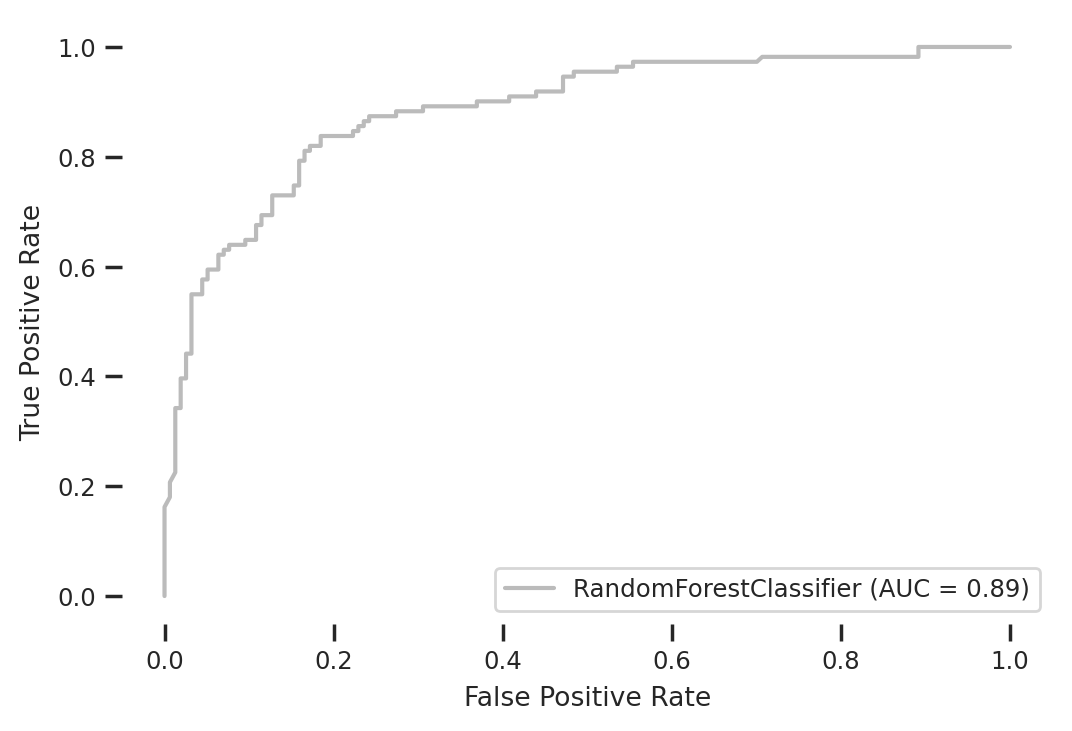

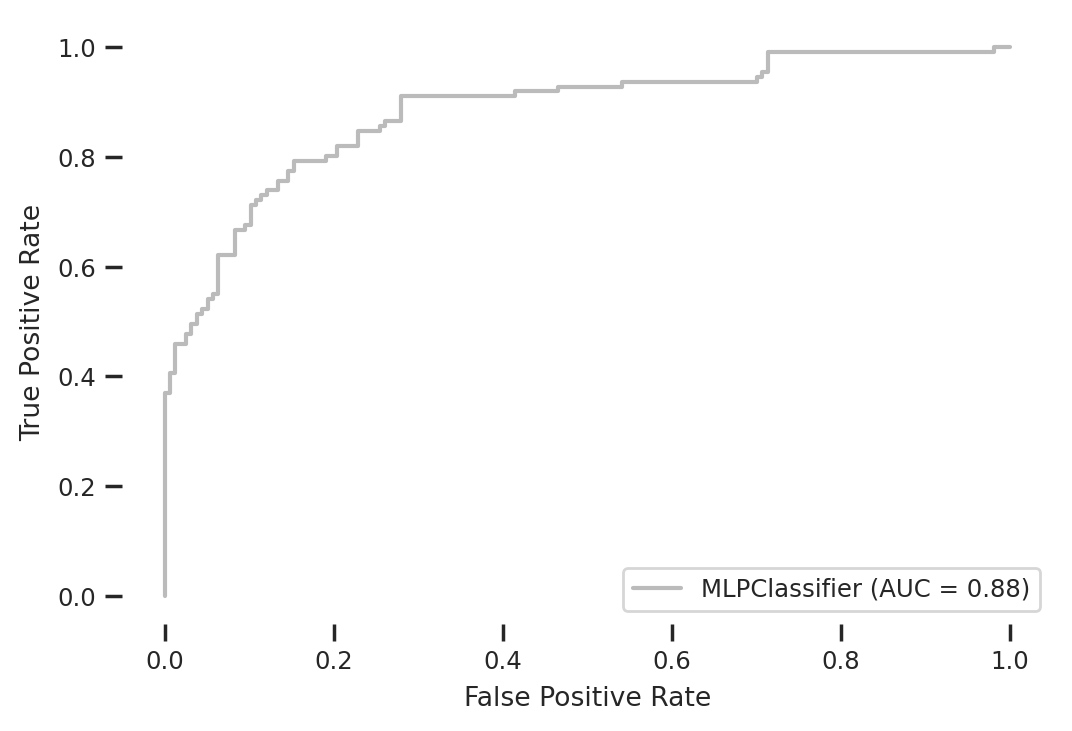

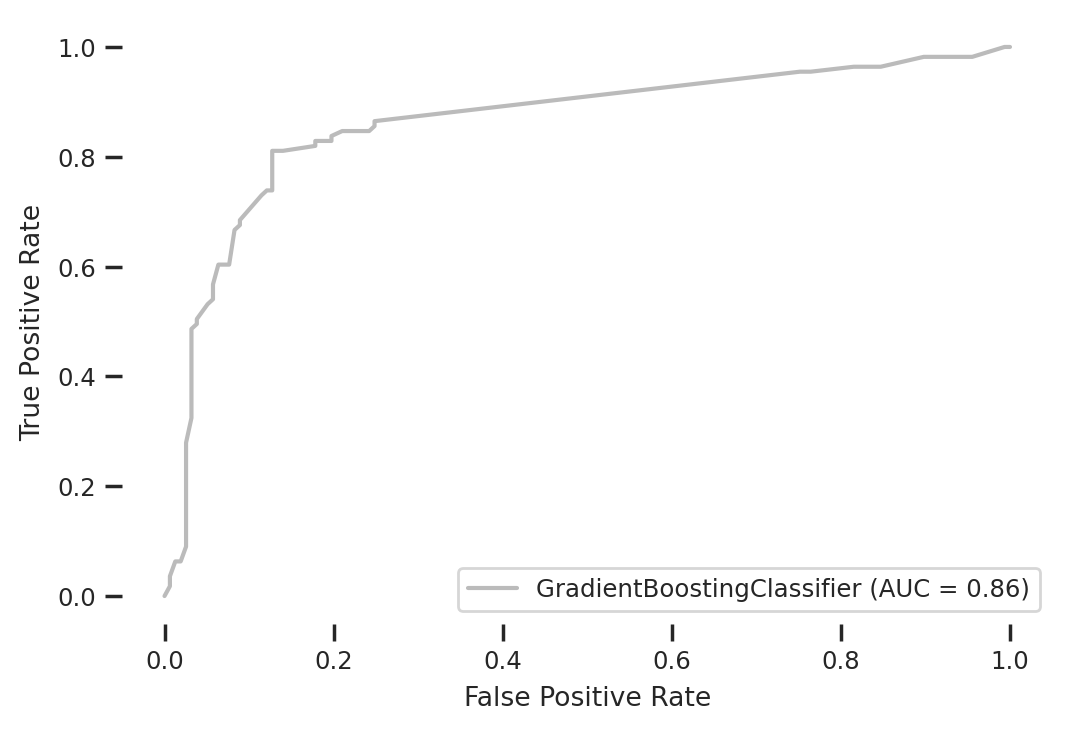

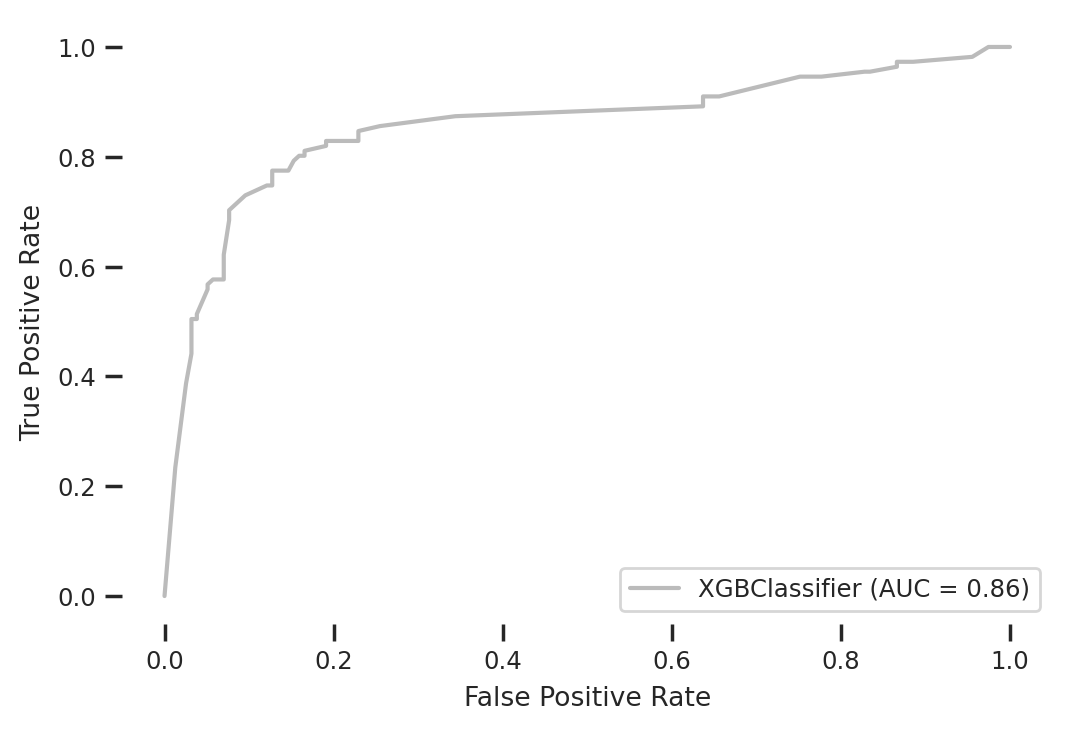

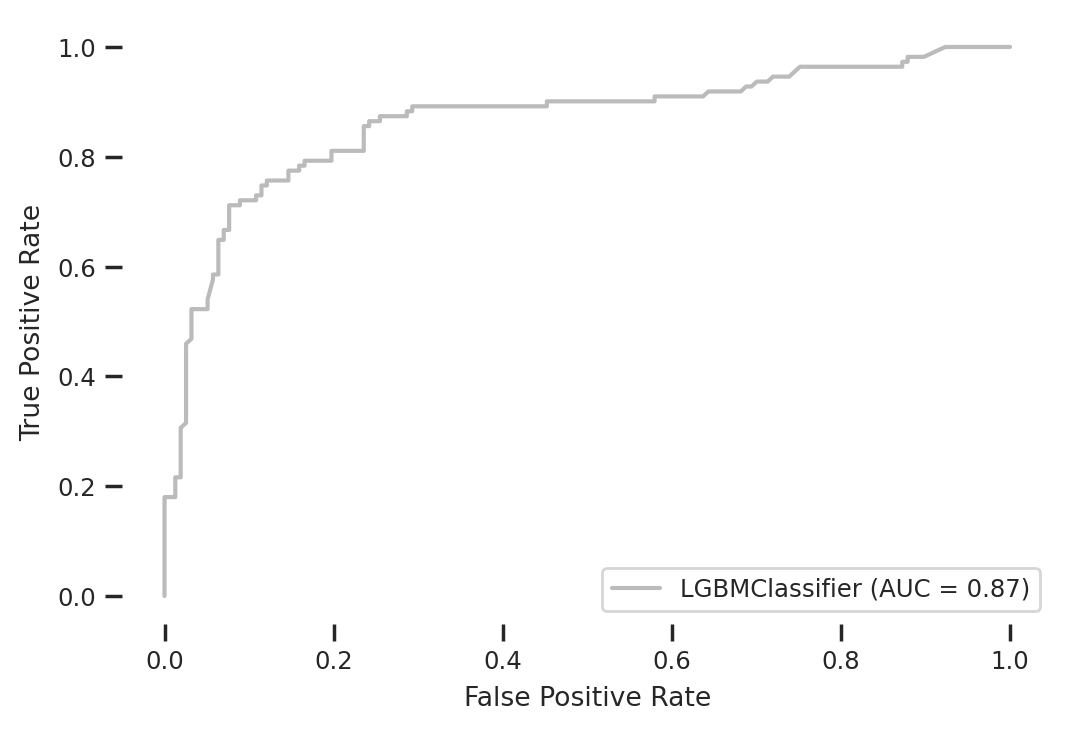

In [71]:
# Generate ROC Curves
for model in models:
    plot_roc_curve(model['Model'], test_features, test_labels);